Data Loading & Preprocessing - AIO

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_es = pd.DataFrame()
for i in range(1, 6):
    df_temp = pd.read_csv(f'ES_part_{i}.csv')
    df_es = pd.concat([df_es, df_temp], ignore_index=True)

df_surprise = pd.read_csv('US_economic_releases_events.csv')

df_surprise.drop(columns=['S', 'Month', 'Surv(A)', 'Surv(H)', 'Surv(L)',], inplace=True)

df_surprise.drop(columns=['Flag', 'Country/Region', 'Day', 'C', 'Category','Subcategory', 'Std Dev', 'Period', 'Actual'])

# Dropping all rows for which surprise column has NaN or 0 value
df_surprise.dropna(subset=['Surprise'], inplace=True)
df_surprise = df_surprise[df_surprise['Surprise'] != 0]

df_surprise.replace("--", pd.NA, inplace=True)

# Redoing dropping all rows for which surprise column has NaN or 0 value
df_surprise.dropna(subset=['Surprise'], inplace=True)
df_surprise = df_surprise[df_surprise['Surprise'] != 0]

# Convert 'Surprise' column to float
df_surprise['Surprise'] = pd.to_numeric(df_surprise['Surprise'], errors='coerce')

# Again filtering out rows where 'Surprise' is 0 or NaN
df_surprise = df_surprise[df_surprise['Surprise'] != 0].dropna(subset=['Surprise'])

df_surprise.dropna(subset=['Time'], inplace=True)

# Wincorsizing to get results between 0.5% and 99.5% percentile for Surprise values
lower_bound = df_surprise['Surprise'].quantile(0.005)
upper_bound = df_surprise['Surprise'].quantile(0.995)

df_surprise = df_surprise[(df_surprise['Surprise'] >= lower_bound) & (df_surprise['Surprise'] <= upper_bound)]

# Step 1: Ensure columns are strings
df_surprise['Date'] = df_surprise['Date'].astype(str)
df_surprise['Time'] = df_surprise['Time'].astype(str)

# Step 2: Handle missing times (if any)
df_surprise['Time'] = df_surprise['Time'].fillna('00:00:00')

# Step 3: Combine Date and Time into DateTime
df_surprise['DateTime'] = pd.to_datetime(
    df_surprise['Date'].str[:10] + ' ' + df_surprise['Time'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'  # Converts invalid parsing to NaT instead of raising error
)

# First we drop Date and DateTime and change the column name for Unnamed: 0 to Date

df_surprise.drop(columns=['Date', 'DateTime'], inplace=True)
df_surprise.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Now let's again create a DateTime column with the new Date column and check for number of NaN values
# Step 1: Ensure columns are strings
df_surprise['Date'] = df_surprise['Date'].astype(str)
df_surprise['Time'] = df_surprise['Time'].astype(str)

# Step 2: Handle missing times (if any)
df_surprise['Time'] = df_surprise['Time'].fillna('00:00:00')

# Step 3: Combine Date and Time into DateTime
df_surprise['DateTime'] = pd.to_datetime(
    df_surprise['Date'].str[:10] + ' ' + df_surprise['Time'],
    format='%Y-%m-%d %H:%M:%S',
    errors='coerce'  # Converts invalid parsing to NaT instead of raising error
)

# Step 1: Ensure columns are strings
df_es['Date'] = df_es['Date'].astype(str)
df_es['Time'] = df_es['Time'].astype(str)

# Step 2: Handle missing times (if any) and pad with seconds
df_es['Time'] = df_es['Time'].fillna('00:00')  # Fill missing times
df_es['Time'] = df_es['Time'] + ':00'  # Add seconds to make HH:MM:SS format

# Step 3: Combine Date and Time into DateTime with correct format
df_es['DateTime'] = pd.to_datetime(
    df_es['Date'] + ' ' + df_es['Time'],
    format='%m/%d/%Y %H:%M:%S',  # Matches MM/DD/YYYY date and HH:MM:SS time
    errors='coerce'
)

# Now we create the merged dataframe for our analysis - to allow us to match times of surprise with the price of the future at the time
df_combined = pd.merge(
    df_es,
    df_surprise,
    on='DateTime',
    how='outer',
    suffixes=('_es', '_surprise'),
    indicator=True  # this shows the source of each using suffix
)

# Some surprise announcements might have come before the starting point for the data on the futures, these would be meaningless for our analysis and should thus
# be removed by removing all rows with NaN values for Open

df_combined.dropna(subset=['Open'], inplace=True)


C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_21276\2381584617.py:10: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_surprise = pd.read_csv('US_economic_releases_events.csv')
C:\Users\Jop Brouwer\AppData\Local\Temp\ipykernel_21276\2381584617.py:20: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_surprise.replace("--", pd.NA, inplace=True)


In [2]:
df_es

,Date,Time,Open,Close,Volume,DateTime
0,09/10/1997,00:01:00,0.00,0.00,0,1997-09-10 00:01:00
1,09/10/1997,00:02:00,0.00,0.00,0,1997-09-10 00:02:00
2,09/10/1997,00:03:00,0.00,0.00,0,1997-09-10 00:03:00
3,09/10/1997,00:04:00,0.00,0.00,0,1997-09-10 00:04:00
4,09/10/1997,00:05:00,0.00,0.00,0,1997-09-10 00:05:00
...,...,...,...,...,...,...
9682630,12/19/2024,15:56:00,5941.75,5941.75,318,2024-12-19 15:56:00
9682631,12/19/2024,15:57:00,5941.75,5941.50,386,2024-12-19 15:57:00
9682632,12/19/2024,15:58:00,5941.50,5941.00,484,2024-12-19 15:58:00
9682633,12/19/2024,15:59:00,5940.75,5941.00,6462,2024-12-19 15:59:00


In [3]:
df_surprise

,Date,Period,Event,Ticker,Actual,Prior,Revised,Freq.,First Rev.,Last Rev.,...,Subcategory,R,Day,Surv(M),# Ests.,Std Dev,Surprise,Country/Region,Flag,DateTime
153,1997-06-25,1Q F,GDP Annualized QoQ,GDP CQOQ Index,0.059,0.058,<NA>,Q,<NA>,<NA>,...,NaN,96.296300,Wed,0.058,13.0,0.22,0.45,United States,United States,1997-06-25 07:30:00
198,1997-08-01,Jul,Change in Nonfarm Payrolls,NFP TCH Index,316k,217k,228k,M,228k,265k,...,NaN,99.259300,Fri,70k,20.0,33.84,7.27,United States,United States,1997-08-01 07:30:00
394,1997-12-23,3Q F,GDP Annualized QoQ,GDP CQOQ Index,0.031,0.033,<NA>,Q,<NA>,0.051,...,NaN,96.296300,Tue,0.033,11.0,0.07,-2.98,United States,United States,1997-12-23 07:30:00
523,1998-03-26,4Q F,GDP Annualized QoQ,GDP CQOQ Index,0.037,0.039,<NA>,Q,<NA>,<NA>,...,NaN,96.296300,Thu,0.039,22.0,0.08,-2.52,United States,United States,1998-03-26 07:30:00
569,1998-04-30,1Q A,GDP Annualized QoQ,GDP CQOQ Index,0.042,0.037,<NA>,Q,<NA>,<NA>,...,NaN,96.296300,Thu,0.034,19.0,0.36,2.22,United States,United States,1998-04-30 07:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35992,2024-12-18,Nov P,Building Permits,NHSPATOT Index,1505k,1416k,1419k,M,1419k,1419k,...,NaN,61.185200,Wed,1430k,46.0,22.21,3.38,United States,United States,2024-12-18 07:30:00
35993,2024-12-18,Nov P,Building Permits MoM,NHCHATCH Index,0.061,-0.006,-0.004,M,-0.004,-0.004,...,NaN,31.851900,Wed,0.01,46.0,1.78,2.87,United States,United States,2024-12-18 07:30:00
35994,2024-12-18,3Q,Current Account Balance,USCABAL Index,-$310.9b,-$266.8b,-$275.0b,Q,-$275.0b,-$275.0b,...,NaN,71.111100,Wed,-$287.1b,18.0,6.22,-3.84,United States,United States,2024-12-18 07:30:00
35999,2024-12-18,2024-12-18 00:00:00,FOMC Median Rate Forecast: Next Yr,DOTDY1MD Index,0.03875,0.03375,<NA>,D,<NA>,<NA>,...,NaN,2.222220,Wed,0.03625,12.0,0.12,2.03,United States,United States,2024-12-18 13:00:00


In [4]:
df_combined

,Date_es,Time_es,Open,Close,Volume,DateTime,Date_surprise,Period,Event,Ticker,...,Subcategory,R,Day,Surv(M),# Ests.,Std Dev,Surprise,Country/Region,Flag,_merge
2,09/10/1997,00:01:00,0.00,0.00,0.0,1997-09-10 00:01:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,09/10/1997,00:02:00,0.00,0.00,0.0,1997-09-10 00:02:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,09/10/1997,00:03:00,0.00,0.00,0.0,1997-09-10 00:03:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
5,09/10/1997,00:04:00,0.00,0.00,0.0,1997-09-10 00:04:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6,09/10/1997,00:05:00,0.00,0.00,0.0,1997-09-10 00:05:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9695761,12/19/2024,15:56:00,5941.75,5941.75,318.0,2024-12-19 15:56:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9695762,12/19/2024,15:57:00,5941.75,5941.50,386.0,2024-12-19 15:57:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9695763,12/19/2024,15:58:00,5941.50,5941.00,484.0,2024-12-19 15:58:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
9695764,12/19/2024,15:59:00,5940.75,5941.00,6462.0,2024-12-19 15:59:00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [5]:
# save the last 10% of the combined dataframe to a csv file
df_combined.iloc[int(len(df_combined) * 0.9):].to_csv('combined_datalast 10percdent.csv', index=False)

Neural Network on this dataset

TensorFlow version: 2.19.0
--- Loading and Initial Data Preparation ---
DateTime column processed and set as index for base DataFrame.
Base DataFrame prepared.

--- Running Analysis for Window Size: 10 minutes ---
   Preprocessing...
   Found 23068 events with valid future returns.
   Target distribution: {1: np.int64(7957), 2: np.int64(7660), 0: np.int64(7451)}
   Data split: Train=18454, Test=4614
   Features preprocessed. Train shape: (18454, 144), Test shape: (4614, 144)
   Defining Model...
   Training Model...
   Training completed in 17 epochs (stopped early: Yes).
   Simulating Trading...
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step
   Predicted signal distribution: {0: np.int64(2095), -1: np.int64(1320), 1: np.int64(1199)}
   Evaluating Performance...
   Finished analysis for 10 min window in 11.94 seconds.
   Plotting cumulative returns for 10 min window...


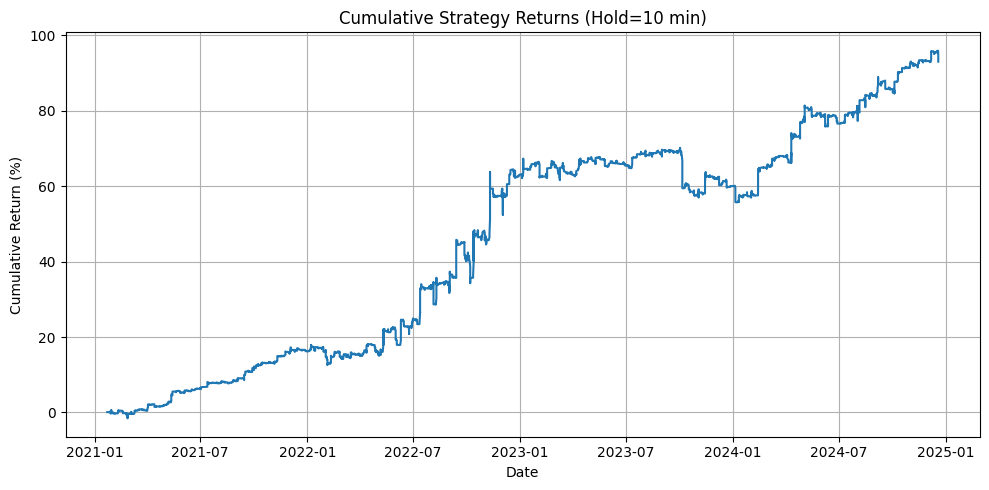


--- Running Analysis for Window Size: 20 minutes ---
   Preprocessing...
   Found 23068 events with valid future returns.
   Target distribution: {2: np.int64(8417), 0: np.int64(8156), 1: np.int64(6495)}
   Data split: Train=18454, Test=4614
   Features preprocessed. Train shape: (18454, 144), Test shape: (4614, 144)
   Defining Model...
   Training Model...
   Training completed in 13 epochs (stopped early: Yes).
   Simulating Trading...
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step
   Predicted signal distribution: {1: np.int64(2280), -1: np.int64(1517), 0: np.int64(817)}
   Evaluating Performance...
   Finished analysis for 20 min window in 9.39 seconds.
   Plotting cumulative returns for 20 min window...


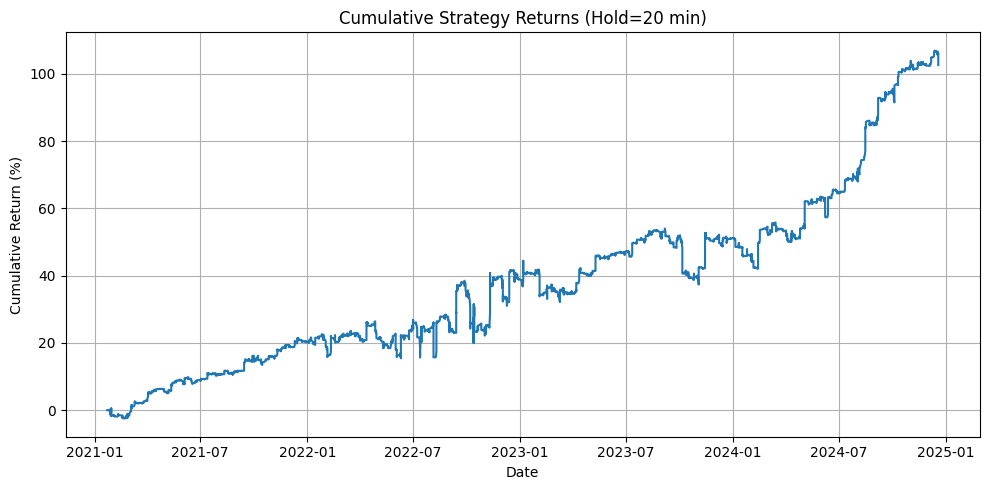


--- Running Analysis for Window Size: 40 minutes ---
   Preprocessing...
   Found 23068 events with valid future returns.
   Target distribution: {2: np.int64(9103), 0: np.int64(8793), 1: np.int64(5172)}
   Data split: Train=18454, Test=4614
   Features preprocessed. Train shape: (18454, 144), Test shape: (4614, 144)
   Defining Model...
   Training Model...
   Training completed in 15 epochs (stopped early: Yes).
   Simulating Trading...
145/145 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step
   Predicted signal distribution: {1: np.int64(2706), -1: np.int64(1479), 0: np.int64(429)}
   Evaluating Performance...
   Finished analysis for 40 min window in 10.59 seconds.
   Plotting cumulative returns for 40 min window...


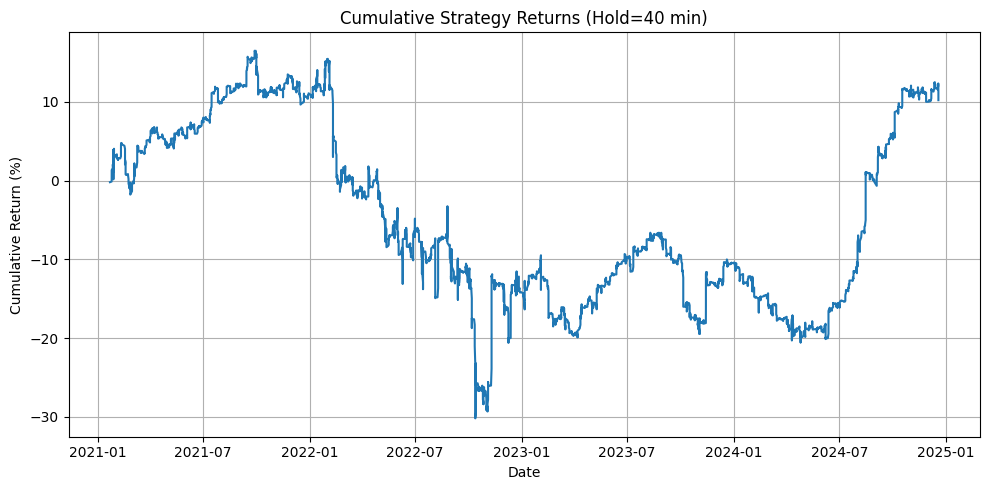



--- Summary Results Across All Window Sizes ---
| window_minutes   | total_return   | test_accuracy   | num_trades   | yearly_returns_str                                     |
|:-----------------|:---------------|:----------------|:-------------|:-------------------------------------------------------|
| 10               | 92.9969%       | 38.2965%        | 2519         | 2021: 16.22%, 2022: 40.25%, 2023: -1.83%, 2024: 20.61% |
| 20               | 102.6125%      | 38.7516%        | 3797         | 2021: 20.41%, 2022: 15.49%, 2023: 8.61%, 2024: 34.15%  |
| 40               | 10.1963%       | 39.8570%        | 4185         | 2021: 11.07%, 2022: -22.69%, 2023: 4.25%, 2024: 23.10% |

Detailed Yearly Returns:

  Window: 10 minutes
| Year   | Strategy_Return   |
|:-------|:------------------|
| 2021   | 16.2199%          |
| 2022   | 40.2541%          |
| 2023   | -1.8285%          |
| 2024   | 20.6059%          |

  Window: 20 minutes
| Year   | Strategy_Return   |
|:-------|:------------

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import time # To time the process
import warnings

# Suppress specific warnings if desired (e.g., SettingWithCopyWarning)
# warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Attempt to import matplotlib for plotting
try:
    import matplotlib.pyplot as plt
    MATPLOTLIB_AVAILABLE = True
except ImportError:
    MATPLOTLIB_AVAILABLE = False
    print("Warning: matplotlib not found. Install using 'pip install matplotlib' to see performance plots.")

# --- Check TensorFlow Installation ---
try:
    print(f"TensorFlow version: {tf.__version__}") # Verify TensorFlow is imported
except NameError:
    print("TensorFlow not found. Please install it using 'pip install tensorflow'")
    print("You need to run 'pip install tensorflow' in your terminal/command prompt, not in this script.")
    exit()
except Exception as e:
    print(f"An error occurred importing TensorFlow: {e}")
    exit()

# --- Configuration ---
WINDOW_SIZES = [10, 20, 40] # Holding periods to test in minutes
RETURN_THRESHOLD = 0.0005  # Threshold for defining Long/Short signal (e.g., 0.05% move)
TEST_SIZE = 0.2  # Proportion of data to use for testing
RANDOM_STATE = 42 # For reproducibility
EPOCHS = 100 # Max epochs for training
PATIENCE = 10 # Early stopping patience
BATCH_SIZE = 32

# --- Load and Initial Prepare Data (Do this once) ---
print("--- Loading and Initial Data Preparation ---")
try:
    # Ensure df_combined is loaded. If not, uncomment and adjust the path:
    # df_combined = pd.read_csv('combined_datalast 10percdent.csv')
    if 'df_combined' not in locals() and 'df_combined' not in globals():
         raise NameError("df_combined is not defined. Please load your data.")

    # Make a copy to avoid modifying the original DataFrame if it's used elsewhere
    df_base = df_combined.copy()

    # Ensure DateTime is parsed correctly and set as index
    df_base['DateTime'] = pd.to_datetime(df_base['DateTime'], errors='coerce')
    df_base = df_base.dropna(subset=['DateTime']) # Drop rows where conversion failed
    df_base = df_base.sort_values('DateTime')
    df_base = df_base.set_index('DateTime')
    print("DateTime column processed and set as index for base DataFrame.")

    # Keep only necessary columns
    required_cols = ['Close', 'Event', 'Surprise']
    missing_cols = [col for col in required_cols if col not in df_base.columns]
    if missing_cols:
        raise ValueError(f"Error: Missing required columns in base DataFrame: {missing_cols}")

    df_base = df_base[required_cols].copy()
    print("Base DataFrame prepared.")

except FileNotFoundError:
    print("Error: CSV file not found. Ensure 'df_combined' is loaded.")
    exit()
except NameError as e:
    print(f"Error: {e}")
    exit()
except KeyError:
    print("Error: 'DateTime' column not found during initial preparation.")
    exit()
except ValueError as e:
     print(e)
     exit()
except Exception as e:
    print(f"An error occurred during initial data preparation: {e}")
    exit()


# --- Function to run analysis for a given window size ---
def run_analysis_for_window(df_base, window_minutes, threshold, test_size, random_state, epochs, patience, batch_size):
    """
    Performs preprocessing, NN training, simulation, plotting and evaluation for a specific holding window.
    """
    print(f"\n--- Running Analysis for Window Size: {window_minutes} minutes ---")
    start_time = time.time()

    # --- 1. Data Preprocessing (Specific to this window size) ---
    print("   Preprocessing...")
    df_analysis = df_base.dropna(subset=['Surprise', 'Event']).copy()

    if len(df_analysis) == 0:
        print("   Error: No rows with surprise events found.")
        return None

    if df_analysis.index.duplicated().any():
        print(f"   Warning: Duplicate DateTime index values found after filtering for surprises. Count: {df_analysis.index.duplicated().sum()}")

    # Define the target variable based on the current window size
    df_analysis['Future_Close'] = df_analysis.index.map(lambda dt: df_base['Close'].asof(dt + pd.Timedelta(minutes=window_minutes)))
    df_analysis['Future_Return'] = (df_analysis['Future_Close'] - df_analysis['Close']) / df_analysis['Close']
    df_analysis = df_analysis.dropna(subset=['Future_Return'])

    if len(df_analysis) == 0:
        print(f"   Error: No rows remaining after calculating future returns for {window_minutes} min window.")
        return None

    df_analysis['Signal'] = 0
    df_analysis.loc[df_analysis['Future_Return'] > threshold, 'Signal'] = 1
    df_analysis.loc[df_analysis['Future_Return'] < -threshold, 'Signal'] = -1
    signal_mapping = {-1: 0, 0: 1, 1: 2}
    df_analysis['Target'] = df_analysis['Signal'].map(signal_mapping)

    print(f"   Found {len(df_analysis)} events with valid future returns.")
    print(f"   Target distribution: {dict(df_analysis['Target'].value_counts())}")

    # Select Features (X) and Target (y)
    features = ['Surprise', 'Event']
    X = df_analysis[features]
    y = df_analysis['Target']

    # Split data chronologically
    split_index = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
    y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
    df_test = df_analysis.iloc[split_index:].copy()

    if df_test.index.duplicated().any():
         print(f"   Warning: Duplicate DateTime index values found in test set. Count: {df_test.index.duplicated().sum()}")

    if len(X_train) == 0 or len(X_test) == 0:
        print("   Error: Not enough data to create train/test split.")
        return None

    print(f"   Data split: Train={len(X_train)}, Test={len(X_test)}")

    # Preprocessing Pipeline
    numeric_features = ['Surprise']
    categorical_features = ['Event']
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
        ],
        remainder='passthrough'
    )

    # Apply preprocessing
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)
    y_train_cat = to_categorical(y_train, num_classes=3)
    y_test_cat = to_categorical(y_test, num_classes=3)
    print(f"   Features preprocessed. Train shape: {X_train_processed.shape}, Test shape: {X_test_processed.shape}")

    # --- 2. Neural Network Model Definition ---
    print("   Defining Model...")
    input_dim = X_train_processed.shape[1]
    model = Sequential(name=f"MacroSurprise_Trader_{window_minutes}min")
    model.add(Input(shape=(input_dim,), name="Input_Layer"))
    model.add(Dense(64, activation='relu', name="Hidden_Layer_1"))
    model.add(Dropout(0.3, name="Dropout_1"))
    model.add(Dense(32, activation='relu', name="Hidden_Layer_2"))
    model.add(Dropout(0.3, name="Dropout_2"))
    model.add(Dense(3, activation='softmax', name="Output_Layer"))

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # --- 3. Model Training ---
    print("   Training Model...")
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=0)
    history = model.fit(X_train_processed, y_train_cat,
                        epochs=epochs, batch_size=batch_size, validation_split=0.2,
                        callbacks=[early_stopping], verbose=0)
    print(f"   Training completed in {history.epoch[-1]+1} epochs (stopped early: {'Yes' if early_stopping.stopped_epoch > 0 else 'No'}).")

    # --- 4. Trading Strategy Simulation ---
    print("   Simulating Trading...")
    predictions_prob = model.predict(X_test_processed)
    predicted_signals_raw = np.argmax(predictions_prob, axis=1)
    reverse_signal_mapping = {0: -1, 1: 0, 2: 1}
    predicted_signals = np.array([reverse_signal_mapping[pred] for pred in predicted_signals_raw])

    df_test['Predicted_Signal'] = predicted_signals
    df_test['Strategy_Return'] = 0.0

    # Assign strategy returns based on predicted signal and actual future return
    long_mask = df_test['Predicted_Signal'] == 1
    short_mask = df_test['Predicted_Signal'] == -1
    df_test.loc[long_mask, 'Strategy_Return'] = df_test.loc[long_mask, 'Future_Return'].values
    df_test.loc[short_mask, 'Strategy_Return'] = -df_test.loc[short_mask, 'Future_Return'].values

    # Calculate cumulative returns ONLY if there are non-zero strategy returns
    if (df_test['Strategy_Return'] != 0).any():
        df_test['Cumulative_Strategy_Return'] = (1 + df_test['Strategy_Return']).cumprod() - 1
    else:
        df_test['Cumulative_Strategy_Return'] = 0.0 # Assign zero cumulative return if no trades happened or all returns were zero
    print(f"   Predicted signal distribution: {dict(df_test['Predicted_Signal'].value_counts())}")

    # --- 5. Performance Evaluation ---
    print("   Evaluating Performance...")
    # Handle potential NaN or empty results in cumulative return
    total_return = df_test['Cumulative_Strategy_Return'].iloc[-1] if not df_test.empty and pd.notna(df_test['Cumulative_Strategy_Return'].iloc[-1]) else 0

    df_test['Year'] = df_test.index.year
    yearly_returns = df_test.groupby('Year')['Strategy_Return'].apply(lambda x: (1 + x).prod() - 1)
    test_loss, test_accuracy = model.evaluate(X_test_processed, y_test_cat, verbose=0)

    end_time = time.time()
    print(f"   Finished analysis for {window_minutes} min window in {end_time - start_time:.2f} seconds.")

    results = {
        'window_minutes': window_minutes,
        'total_return': total_return,
        'yearly_returns': yearly_returns,
        'test_accuracy': test_accuracy,
        'test_loss': test_loss,
        'num_trades': len(df_test[df_test['Predicted_Signal'] != 0]),
        'df_test': df_test # Store test results for plotting later if needed
    }

    # --- 6. Plotting Performance ---
    if MATPLOTLIB_AVAILABLE and not df_test.empty and 'Cumulative_Strategy_Return' in df_test.columns:
        print(f"   Plotting cumulative returns for {window_minutes} min window...")
        try:
            plt.figure(figsize=(10, 5))
            plt.plot(df_test.index, df_test['Cumulative_Strategy_Return'] * 100)
            plt.title(f'Cumulative Strategy Returns (Hold={window_minutes} min)')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Return (%)')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"   An error occurred during plotting: {e}")
    elif not MATPLOTLIB_AVAILABLE:
         print("   Skipping plot: matplotlib not available.")
    else:
         print("   Skipping plot: No data to plot.")


    return results


# --- Run analysis for all specified window sizes ---
all_results = []
for window in WINDOW_SIZES:
    result = run_analysis_for_window(df_base, window, RETURN_THRESHOLD, TEST_SIZE, RANDOM_STATE, EPOCHS, PATIENCE, BATCH_SIZE)
    if result:
        all_results.append(result)

# --- Display Summary Results ---
print("\n\n--- Summary Results Across All Window Sizes ---")
if not all_results:
    print("No results were generated. Check data and configurations.")
else:
    summary_df = pd.DataFrame(all_results).drop(columns=['df_test']) # Drop the df_test column before printing summary
    # Format returns and accuracy as percentages for better readability
    summary_df['total_return'] = summary_df['total_return'].map('{:.4%}'.format)
    summary_df['test_accuracy'] = summary_df['test_accuracy'].map('{:.4%}'.format)

    # Prepare yearly returns for display
    summary_df['yearly_returns_str'] = summary_df['yearly_returns'].apply(
        lambda x: ', '.join([f"{yr}: {ret:.2%}" for yr, ret in x.items()]) if isinstance(x, pd.Series) and not x.empty else "N/A"
    )

    print(summary_df[['window_minutes', 'total_return', 'test_accuracy', 'num_trades', 'yearly_returns_str']].to_markdown(index=False, numalign="left", stralign="left"))

    # Optionally print detailed yearly returns again if needed (formatted)
    print("\nDetailed Yearly Returns:")
    for res in all_results:
        print(f"\n  Window: {res['window_minutes']} minutes")
        if not res['yearly_returns'].empty:
            # Print formatted yearly returns
            formatted_yearly = res['yearly_returns'].map('{:.4%}'.format)
            print(formatted_yearly.to_markdown(numalign="left", stralign="left"))
        else:
            print("    No yearly returns calculated.")


# --- Full Explanation ---
print("\n--- Explanation ---")
print(f"""
This script builds, trains, and evaluates a neural network trading strategy based on macroeconomic surprises for multiple holding periods ({WINDOW_SIZES} minutes).

1.  **Data Loading and Initial Preparation:**
    * The script starts by loading your data into the `df_combined` DataFrame (ensure it's loaded in your environment or uncomment the `pd.read_csv` line).
    * It performs essential initial setup: converts the 'DateTime' column to datetime objects, sets it as the DataFrame index, sorts the data chronologically, and selects only the necessary columns ('Close', 'Event', 'Surprise'). This prepared DataFrame is stored in `df_base`.

2.  **Analysis Function (`run_analysis_for_window`):**
    * This function encapsulates the entire process for a single holding period (window size). It's called iteratively for each value in `WINDOW_SIZES`.
    * **Preprocessing:**
        * Filters `df_base` to keep only rows where a surprise event occurred ('Surprise' is not NaN).
        * **Target Variable:** Calculates the future return based on the specified `window_minutes`. It looks up the closing price `window_minutes` after the event timestamp in the `df_base` DataFrame.
        * Defines a trading `Signal` (1 for Long, -1 for Short, 0 for No Trade) based on whether the `Future_Return` exceeds the `RETURN_THRESHOLD`.
        * Maps this `Signal` to a categorical `Target` (0: Short, 1: No Trade, 2: Long) for the neural network.
        * **Features:** Selects 'Surprise' and 'Event' as input features (X).
        * **Splitting:** Splits the data (X and y) chronologically into training and testing sets to prevent lookahead bias. 80% for training, 20% for testing by default.
        * **Preprocessing Pipeline:** Uses `ColumnTransformer` to apply different preprocessing steps to different columns:
            * `StandardScaler` is applied to the numerical 'Surprise' feature (scales to zero mean, unit variance).
            * `OneHotEncoder` is applied to the categorical 'Event' feature (converts each event type into a binary column). `handle_unknown='ignore'` prevents errors if the test set contains events not seen during training.
        * Applies the fitted pipeline to transform both training and testing features.
        * Converts the integer target variable (`y_train`, `y_test`) into one-hot encoded format (`y_train_cat`, `y_test_cat`) suitable for the model's output layer.
    * **Neural Network Structure (MLP):**
        * Defines a Sequential Multi-Layer Perceptron (MLP) model using TensorFlow/Keras.
        * **Input Layer:** Size matches the number of processed features.
        * **Hidden Layers:** Two dense layers (64 and 32 neurons) with ReLU activation functions. ReLU is chosen for its efficiency and ability to handle non-linearities.
        * **Dropout:** Dropout layers (rate 0.3) are included after hidden layers for regularization, helping prevent overfitting by randomly ignoring some neurons during training.
        * **Output Layer:** A Dense layer with 3 neurons (one for each class: Short, No Trade, Long) and a Softmax activation function. Softmax outputs probabilities for each class, summing to 1.
        * **Compilation:** Compiles the model using the Adam optimizer and 'categorical_crossentropy' loss function (appropriate for multi-class classification with one-hot encoded labels). Tracks 'accuracy' during training.
    * **Model Training:**
        * Trains the compiled model on the processed training data (`X_train_processed`, `y_train_cat`).
        * Uses a validation split (20% of training data) to monitor performance on unseen data during training.
        * Implements **Early Stopping**: Monitors the validation loss (`val_loss`) and stops training if it doesn't improve for a specified `patience` number of epochs (10), restoring the weights from the best epoch. This prevents overfitting and saves time.
    * **Trading Strategy Simulation:**
        * Uses the trained model to predict class probabilities (`predict`) on the processed test set (`X_test_processed`).
        * Determines the final predicted signal (-1, 0, or 1) by taking the class with the highest probability (`argmax`).
        * Calculates the `Strategy_Return` for each event in the test set:
            * If predicted Long (1), return = `Future_Return`.
            * If predicted Short (-1), return = -`Future_Return`.
            * If predicted No Trade (0), return = 0.
            * **Important:** The assignment uses `.values` on the right-hand side (`df_test.loc[mask, 'Future_Return'].values`) to correctly handle potential duplicate timestamps in the test set index.
        * Computes the cumulative product of `(1 + Strategy_Return)` to get the overall strategy equity curve.
    * **Performance Evaluation:**
        * Calculates the total cumulative return over the test period.
        * Calculates annualized returns by grouping strategy returns by year.
        * Evaluates the model's classification accuracy and loss on the test set using `model.evaluate`.
    * **Plotting:**
        * If `matplotlib` is installed, it plots the cumulative strategy return curve (%) against time for the test period, providing a visual representation of performance for the specific window size.
    * **Return Results:** The function returns a dictionary containing key performance metrics and the test data DataFrame for the analyzed window.

3.  **Iteration and Summary:**
    * The main script iterates through each `window` specified in `WINDOW_SIZES`.
    * It calls `run_analysis_for_window` for each window size.
    * The results from each run are collected.
    * Finally, it prints a summary table comparing the total return, accuracy, number of trades, and yearly returns across all tested window sizes, allowing you to easily compare their effectiveness. Detailed yearly returns are also printed separately.
""")

With 1 year rolling window

TensorFlow version: 2.19.0
--- Loading and Initial Data Preparation ---
DateTime column processed and set as index for base DataFrame.
Base DataFrame prepared. Found 23068 potential surprise events overall.
Data range for events: 1997-12-23 07:30:00 to 2024-12-18 13:00:00

===== Processing Holding Period: 10 minutes =====
  Preparing target variable for 10 min window...
  Prepared 23068 events with targets for 10 min window.

  --- Fold 1 (10 min) ---
    Train Period: 1997-12-23 to 1998-12-23
    Test Period:  1998-12-23 to 1999-12-23
    Train events: 169, Test events: 430
    Features preprocessed. Train shape: (169, 36), Test shape: (430, 36)
    Defining and Training Model...
    Training completed in 56 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
    Fold 1 processing complete.

  --- Fold 2 (10 min) ---
    Train Period: 1998-12-23 to 1999-12-23
    Test Period:  1999-12-23 to 2000-12-23
    Train events: 430, Test events: 468
    Fea

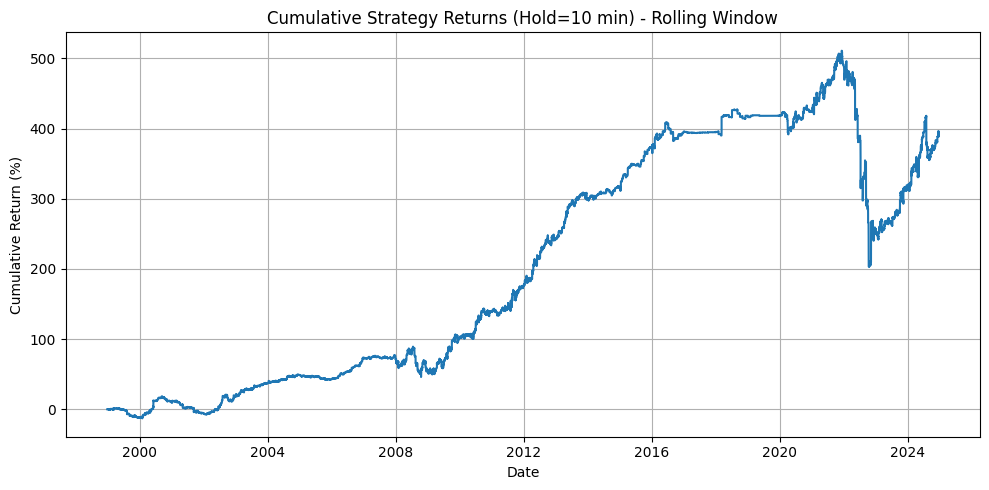


===== Processing Holding Period: 20 minutes =====
  Preparing target variable for 20 min window...
  Prepared 23068 events with targets for 20 min window.

  --- Fold 1 (20 min) ---
    Train Period: 1997-12-23 to 1998-12-23
    Test Period:  1998-12-23 to 1999-12-23
    Train events: 169, Test events: 430
    Features preprocessed. Train shape: (169, 36), Test shape: (430, 36)
    Defining and Training Model...
    Training completed in 26 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
    Fold 1 processing complete.

  --- Fold 2 (20 min) ---
    Train Period: 1998-12-23 to 1999-12-23
    Test Period:  1999-12-23 to 2000-12-23
    Train events: 430, Test events: 468
    Features preprocessed. Train shape: (430, 44), Test shape: (468, 44)
    Defining and Training Model...
    Training completed in 31 epochs.
    Simulating Trading on Test Period...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
    Fold 2 processing complete.

  --- Fold 3 (20 min)

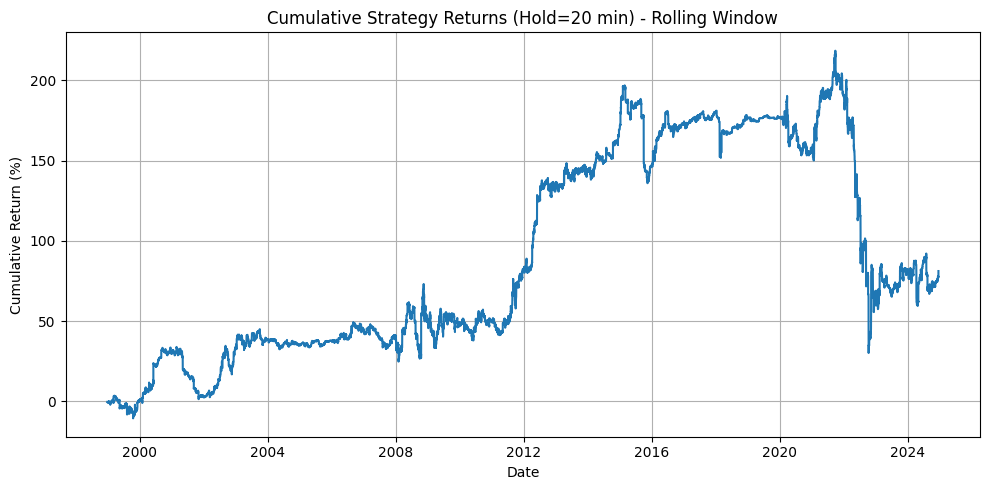


===== Processing Holding Period: 40 minutes =====
  Preparing target variable for 40 min window...
  Prepared 23068 events with targets for 40 min window.

  --- Fold 1 (40 min) ---
    Train Period: 1997-12-23 to 1998-12-23
    Test Period:  1998-12-23 to 1999-12-23
    Train events: 169, Test events: 430
    Features preprocessed. Train shape: (169, 36), Test shape: (430, 36)
    Defining and Training Model...
    Training completed in 66 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
    Fold 1 processing complete.

  --- Fold 2 (40 min) ---
    Train Period: 1998-12-23 to 1999-12-23
    Test Period:  1999-12-23 to 2000-12-23
    Train events: 430, Test events: 468
    Features preprocessed. Train shape: (430, 44), Test shape: (468, 44)
    Defining and Training Model...
    Training completed in 19 epochs.
    Simulating Trading on Test Period...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
    Fold 2 processing complete.

  --- Fold 3 (40 min)

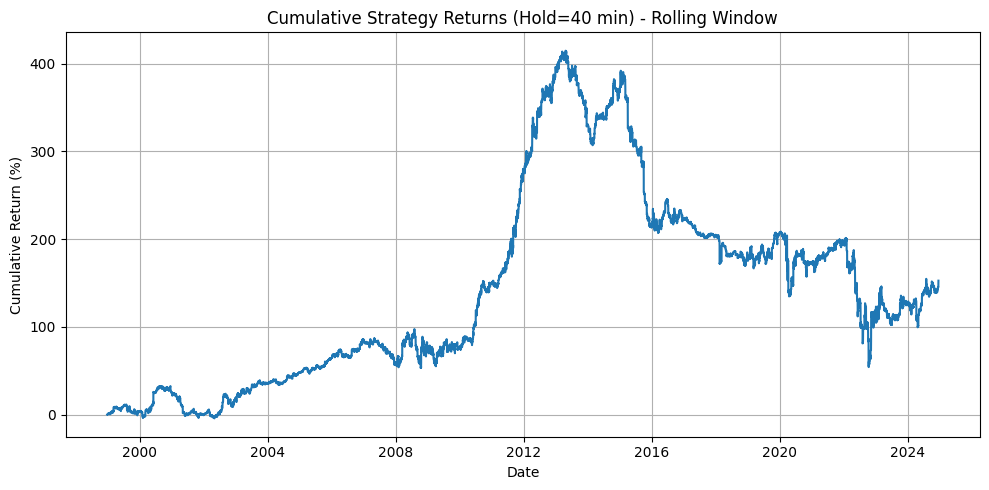



===== Final Summary Results Across All Window Sizes (Rolling Window Validation) =====
| window_minutes   | total_return   | overall_accuracy   | num_trades   | yearly_returns_str                                                                                                                                                                                                                                                                                                                                                                     |
|:-----------------|:---------------|:-------------------|:-------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 10      

In [10]:
import pandas as pd
import numpy as np
# No train_test_split needed for rolling window approach
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import time # To time the process
import datetime
import warnings

# Suppress specific warnings if desired
# warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Attempt to import matplotlib for plotting
try:
    import matplotlib.pyplot as plt
    MATPLOTLIB_AVAILABLE = True
except ImportError:
    MATPLOTLIB_AVAILABLE = False
    print("Warning: matplotlib not found. Install using 'pip install matplotlib' to see performance plots.")

# --- Check TensorFlow Installation ---
try:
    print(f"TensorFlow version: {tf.__version__}")
except NameError:
    print("TensorFlow not found. Please install it using 'pip install tensorflow'")
    exit()
except Exception as e:
    print(f"An error occurred importing TensorFlow: {e}")
    exit()

# --- Configuration ---
WINDOW_SIZES = [10, 20, 40] # Holding periods to test in minutes
RETURN_THRESHOLD = 0.0005  # Threshold for defining Long/Short signal
# Rolling Window Parameters
TRAIN_WINDOW_YEARS = 1
TEST_WINDOW_YEARS = 1
# NN Parameters
EPOCHS = 100
PATIENCE = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# --- Load and Initial Prepare Data (Do this once) ---
print("--- Loading and Initial Data Preparation ---")
try:
    # Ensure df_combined is loaded
    if 'df_combined' not in locals() and 'df_combined' not in globals():
         raise NameError("df_combined is not defined. Please load your data.")

    df_base = df_combined.copy()
    df_base['DateTime'] = pd.to_datetime(df_base['DateTime'], errors='coerce')
    df_base = df_base.dropna(subset=['DateTime'])
    df_base = df_base.sort_values('DateTime')
    df_base = df_base.set_index('DateTime')
    print("DateTime column processed and set as index for base DataFrame.")

    required_cols = ['Close', 'Event', 'Surprise']
    missing_cols = [col for col in required_cols if col not in df_base.columns]
    if missing_cols:
        raise ValueError(f"Error: Missing required columns: {missing_cols}")

    df_base = df_base[required_cols].copy()
    # Filter out rows without surprise data EARLY ON
    # This df_analysis_base contains all potential events across the full timeline
    df_analysis_base = df_base.dropna(subset=['Surprise', 'Event']).copy()

    if df_analysis_base.empty:
        raise ValueError("No rows with surprise events found in the entire dataset.")

    print(f"Base DataFrame prepared. Found {len(df_analysis_base)} potential surprise events overall.")
    # Determine overall date range for rolling window setup
    data_start_date = df_analysis_base.index.min()
    data_end_date = df_analysis_base.index.max()
    print(f"Data range for events: {data_start_date} to {data_end_date}")

except FileNotFoundError:
    print("Error: CSV file not found.")
    exit()
except NameError as e:
    print(f"Error: {e}")
    exit()
except KeyError:
    print("Error: 'DateTime' column not found.")
    exit()
except ValueError as e:
     print(e)
     exit()
except Exception as e:
    print(f"An error occurred during initial data preparation: {e}")
    exit()


# --- Main Loop for Different Holding Periods ---
all_window_results = []

for window_minutes in WINDOW_SIZES:
    print(f"\n===== Processing Holding Period: {window_minutes} minutes =====")
    start_time_window = time.time()

    # --- Prepare data specific to this holding period ---
    print(f"  Preparing target variable for {window_minutes} min window...")
    df_analysis_window = df_analysis_base.copy()
    # Calculate Future_Close using the original df_base for price lookups
    df_analysis_window['Future_Close'] = df_analysis_window.index.map(lambda dt: df_base['Close'].asof(dt + pd.Timedelta(minutes=window_minutes)))
    df_analysis_window['Future_Return'] = (df_analysis_window['Future_Close'] - df_analysis_window['Close']) / df_analysis_window['Close']
    # Drop events where future return couldn't be calculated (e.g., near end of data)
    df_analysis_window = df_analysis_window.dropna(subset=['Future_Return'])

    if df_analysis_window.empty:
        print(f"  Error: No analysable events remaining after calculating future returns for {window_minutes} min window. Skipping.")
        continue

    # Define Signal and Target (0: Short, 1: No Trade, 2: Long)
    df_analysis_window['Signal'] = 0
    df_analysis_window.loc[df_analysis_window['Future_Return'] > RETURN_THRESHOLD, 'Signal'] = 1
    df_analysis_window.loc[df_analysis_window['Future_Return'] < -RETURN_THRESHOLD, 'Signal'] = -1
    signal_mapping = {-1: 0, 0: 1, 1: 2}
    df_analysis_window['Target'] = df_analysis_window['Signal'].map(signal_mapping)
    print(f"  Prepared {len(df_analysis_window)} events with targets for {window_minutes} min window.")

    # --- Rolling Window Loop ---
    all_fold_results_df = [] # Store test results DataFrames from each fold
    fold_num = 0
    current_train_start_date = data_start_date

    while True:
        fold_num += 1
        # Define train and test periods for this fold
        current_train_end_date = current_train_start_date + pd.DateOffset(years=TRAIN_WINDOW_YEARS)
        current_test_start_date = current_train_end_date
        current_test_end_date = current_test_start_date + pd.DateOffset(years=TEST_WINDOW_YEARS)

        # Check if the test period goes beyond the available data
        if current_test_start_date >= data_end_date:
            print(f"  Stopping rolling window: Test period start ({current_test_start_date.date()}) is beyond data end ({data_end_date.date()}).")
            break

        # Adjust test end date if it exceeds data range
        current_test_end_date = min(current_test_end_date, data_end_date + pd.Timedelta(days=1)) # Ensure last day is included

        print(f"\n  --- Fold {fold_num} ({window_minutes} min) ---")
        print(f"    Train Period: {current_train_start_date.date()} to {current_train_end_date.date()}")
        print(f"    Test Period:  {current_test_start_date.date()} to {current_test_end_date.date()}")

        # Select data for this fold from the window-specific prepared data
        train_df_fold = df_analysis_window.loc[current_train_start_date:current_train_end_date]
        test_df_fold = df_analysis_window.loc[current_test_start_date:current_test_end_date]

        # Check if enough data in fold
        if train_df_fold.empty or test_df_fold.empty:
            print("    Warning: Skipping fold - not enough data in train or test period.")
            # Advance the window by the test period length for the next iteration
            current_train_start_date = current_test_start_date
            continue

        print(f"    Train events: {len(train_df_fold)}, Test events: {len(test_df_fold)}")

        # Prepare features (X) and target (y) for the fold
        features = ['Surprise', 'Event']
        X_train_fold, y_train_fold = train_df_fold[features], train_df_fold['Target']
        X_test_fold, y_test_fold = test_df_fold[features], test_df_fold['Target']

        # Preprocessing Pipeline (fitted on this fold's training data)
        numeric_features = ['Surprise']
        categorical_features = ['Event']
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
            ],
            remainder='passthrough'
        )

        # Fit preprocessor ONLY on training data of this fold
        X_train_processed = preprocessor.fit_transform(X_train_fold)
        # Transform both train and test data of this fold
        X_test_processed = preprocessor.transform(X_test_fold)
        y_train_cat = to_categorical(y_train_fold, num_classes=3)
        y_test_cat = to_categorical(y_test_fold, num_classes=3)
        print(f"    Features preprocessed. Train shape: {X_train_processed.shape}, Test shape: {X_test_processed.shape}")

        # Define, Compile, and Train Model for this fold
        print("    Defining and Training Model...")
        input_dim = X_train_processed.shape[1]
        model = Sequential(name=f"MacroSurprise_Trader_{window_minutes}min_Fold{fold_num}")
        model.add(Input(shape=(input_dim,)))
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(3, activation='softmax'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=0)

        # Need validation data for early stopping - split from the fold's training data
        if len(X_train_processed) > 5: # Need enough samples for a split
             val_split = 0.2
        else:
             val_split = 0.0 # Cannot make validation split

        history = model.fit(X_train_processed, y_train_cat,
                            epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=val_split,
                            callbacks=[early_stopping], verbose=0)
        print(f"    Training completed in {history.epoch[-1]+1} epochs.")

        # Predict and Simulate on the test set of this fold
        print("    Simulating Trading on Test Period...")
        predictions_prob = model.predict(X_test_processed)
        predicted_signals_raw = np.argmax(predictions_prob, axis=1)
        reverse_signal_mapping = {0: -1, 1: 0, 2: 1}
        predicted_signals = np.array([reverse_signal_mapping[pred] for pred in predicted_signals_raw])

        # Create a result DF for this fold's test set
        fold_result_df = test_df_fold.copy()
        fold_result_df['Predicted_Signal'] = predicted_signals
        fold_result_df['Strategy_Return'] = 0.0

        long_mask = fold_result_df['Predicted_Signal'] == 1
        short_mask = fold_result_df['Predicted_Signal'] == -1
        # Use .loc with .values to handle potential duplicate indices within the fold's test set
        fold_result_df.loc[long_mask, 'Strategy_Return'] = fold_result_df.loc[long_mask, 'Future_Return'].values
        fold_result_df.loc[short_mask, 'Strategy_Return'] = -fold_result_df.loc[short_mask, 'Future_Return'].values

        # Store fold results
        all_fold_results_df.append(fold_result_df)
        print(f"    Fold {fold_num} processing complete.")

        # --- Roll window forward ---
        # Move the training window start date forward by the length of the test period
        current_train_start_date = current_test_start_date
        # Alternative: Roll forward by a smaller step (e.g., 1 quarter)
        # current_train_start_date += pd.DateOffset(months=3)


    # --- Aggregation and Evaluation for the holding period ---
    if not all_fold_results_df:
        print(f"  No results generated for holding period {window_minutes} min. Skipping.")
        continue

    # Concatenate results from all folds
    combined_test_results = pd.concat(all_fold_results_df).sort_index()

    # Recalculate cumulative return on combined results
    if (combined_test_results['Strategy_Return'] != 0).any():
         combined_test_results['Cumulative_Strategy_Return'] = (1 + combined_test_results['Strategy_Return']).cumprod() - 1
    else:
         combined_test_results['Cumulative_Strategy_Return'] = 0.0

    # Calculate overall performance metrics
    total_return = combined_test_results['Cumulative_Strategy_Return'].iloc[-1] if not combined_test_results.empty and pd.notna(combined_test_results['Cumulative_Strategy_Return'].iloc[-1]) else 0
    combined_test_results['Year'] = combined_test_results.index.year
    yearly_returns = combined_test_results.groupby('Year')['Strategy_Return'].apply(lambda x: (1 + x).prod() - 1)

    # Calculate overall accuracy (average? weighted average?) - simple average for now
    # Need y_test_cat for all folds combined
    y_test_combined = combined_test_results['Target']
    y_test_combined_cat = to_categorical(y_test_combined, num_classes=3)
    # We don't have combined predictions easily without storing them per fold or rerunning predicts
    # Let's calculate accuracy based on the combined signal comparison for simplicity
    correct_predictions = (combined_test_results['Signal'] == combined_test_results['Predicted_Signal']).sum()
    total_predictions = len(combined_test_results)
    overall_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    # Note: This accuracy differs from model.evaluate loss/accuracy, as it compares Signal (-1,0,1) directly

    num_trades = len(combined_test_results[combined_test_results['Predicted_Signal'] != 0])

    end_time_window = time.time()
    print(f"\n  Finished Rolling Window Analysis for {window_minutes} min in {end_time_window - start_time_window:.2f} seconds.")
    print(f"  Overall Accuracy (Signal vs Predicted): {overall_accuracy:.4%}")
    print(f"  Total Return: {total_return:.4%}")

    # Store results for this window size
    all_window_results.append({
        'window_minutes': window_minutes,
        'total_return': total_return,
        'yearly_returns': yearly_returns,
        'overall_accuracy': overall_accuracy,
        'num_trades': num_trades,
        'combined_test_results': combined_test_results # Store for final plot if needed
    })

    # --- Plotting Performance for this window size ---
    if MATPLOTLIB_AVAILABLE and not combined_test_results.empty and 'Cumulative_Strategy_Return' in combined_test_results.columns:
        print(f"  Plotting cumulative returns for {window_minutes} min window (Combined Folds)...")
        try:
            plt.figure(figsize=(10, 5))
            plt.plot(combined_test_results.index, combined_test_results['Cumulative_Strategy_Return'] * 100)
            plt.title(f'Cumulative Strategy Returns (Hold={window_minutes} min) - Rolling Window')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Return (%)')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"   An error occurred during plotting: {e}")


# --- Display Final Summary Results ---
print("\n\n===== Final Summary Results Across All Window Sizes (Rolling Window Validation) =====")
if not all_window_results:
    print("No results were generated across any window size.")
else:
    summary_list = []
    for res in all_window_results:
        summary_list.append({
            'window_minutes': res['window_minutes'],
            'total_return': res['total_return'],
            'overall_accuracy': res['overall_accuracy'],
            'num_trades': res['num_trades'],
            'yearly_returns': res['yearly_returns'] # Keep series for formatting
        })

    summary_df = pd.DataFrame(summary_list)
    summary_df['total_return'] = summary_df['total_return'].map('{:.4%}'.format)
    summary_df['overall_accuracy'] = summary_df['overall_accuracy'].map('{:.4%}'.format)
    summary_df['yearly_returns_str'] = summary_df['yearly_returns'].apply(
        lambda x: ', '.join([f"{yr}: {ret:.2%}" for yr, ret in x.items()]) if isinstance(x, pd.Series) and not x.empty else "N/A"
    )

    print(summary_df[['window_minutes', 'total_return', 'overall_accuracy', 'num_trades', 'yearly_returns_str']].to_markdown(index=False, numalign="left", stralign="left"))

    print("\nDetailed Yearly Returns (Combined Folds):")
    for res in all_window_results:
        print(f"\n  Window: {res['window_minutes']} minutes")
        if not res['yearly_returns'].empty:
            formatted_yearly = res['yearly_returns'].map('{:.4%}'.format)
            print(formatted_yearly.to_markdown(numalign="left", stralign="left"))
        else:
            print("    No yearly returns calculated.")


# --- Full Explanation ---
print("\n--- Explanation ---")
print(f"""
This script implements and evaluates the neural network trading strategy using a **Rolling Window Validation** approach, testing across multiple holding periods ({WINDOW_SIZES} minutes).

1.  **Data Loading and Initial Preparation:**
    * Similar to before, data is loaded, DateTime index is set, and essential columns are selected.
    * Crucially, it filters for all potential surprise events (`df_analysis_base`) across the entire dataset upfront to establish the full timeline for rolling window analysis.

2.  **Outer Loop (Holding Periods):**
    * The script iterates through each `window_minutes` (e.g., 10, 20, 40).
    * For each holding period, it calculates the specific `Future_Return` and defines the `Target` variable (Short/NoTrade/Long) for all events in `df_analysis_base`. This creates `df_analysis_window`.

3.  **Inner Loop (Rolling Window Folds):**
    * Inside the holding period loop, a `while` loop implements the rolling window logic.
    * **Fold Definition:** In each iteration (fold), it defines:
        * A training period (e.g., {TRAIN_WINDOW_YEARS} year(s) starting from `current_train_start_date`).
        * A testing period (e.g., the subsequent {TEST_WINDOW_YEARS} year(s)).
    * **Data Selection:** It selects the training and testing data (`train_df_fold`, `test_df_fold`) for the *current fold* from the `df_analysis_window` DataFrame based on the defined dates.
    * **Fold-Specific Preprocessing:**
        * A **new** preprocessing pipeline (`ColumnTransformer` with `StandardScaler` and `OneHotEncoder`) is created.
        * **Crucially, it is `fit` ONLY on the training data of the current fold (`X_train_fold`)**.
        * Both the training and testing data for the current fold are then transformed using this fold-specific fitted preprocessor.
    * **Fold-Specific Model Training:**
        * A **new** neural network model (MLP structure remains the same: Input -> Dense(64,relu)+Dropout -> Dense(32,relu)+Dropout -> Dense(3,softmax)) is defined and compiled for each fold.
        * The model is trained **only on the training data of the current fold** (`X_train_processed`, `y_train_cat`).
        * Early stopping is used with a validation split taken from the fold's training data.
    * **Fold-Specific Prediction & Simulation:**
        * The model trained for the current fold is used to predict signals on the **test data of the current fold** (`X_test_processed`).
        * Trading simulation (calculating `Strategy_Return` based on predicted signals and actual `Future_Return`) is performed on the test data for this fold.
        * The results (including signals, returns, etc.) for the fold's test period are stored in `fold_result_df`.
    * **Window Rolling:** The `current_train_start_date` is moved forward (typically by the length of the test period) to define the next fold. The loop continues until the test period extends beyond the available data.

4.  **Aggregation and Evaluation (Per Holding Period):**
    * After the inner rolling window loop completes for a specific `window_minutes`:
        * The test results (`fold_result_df`) from all folds are concatenated into `combined_test_results`.
        * Overall performance metrics (Total Return, Yearly Returns, Overall Accuracy) are calculated based on these combined out-of-sample results.
        * The cumulative return curve is plotted for the combined test results.
    * The aggregated results for the current `window_minutes` are stored.

5.  **Final Summary:**
    * After iterating through all `WINDOW_SIZES`, a final summary table compares the performance (Total Return, Accuracy, Trades, Yearly Breakdown) of the strategy for each holding period, based on the robust rolling window validation. This provides a more reliable estimate of out-of-sample performance than a single train-test split.
""")

TensorFlow version: 2.19.0
--- Loading and Initial Data Preparation ---
DateTime column processed and set as index for base DataFrame.
Base DataFrame prepared with lagged returns. Found 10038 potential surprise events overall (after handling duplicates).
Data range for events: 1997-12-23 07:30:00 to 2024-12-18 13:00:00

===== Processing Holding Period: 10 minutes =====
  Preparing target variable for 10 min window...
  Prepared 10038 events with targets for 10 min window.

  --- Fold 1 (10 min) ---
    Train Period: 1997-12-23 to 1998-12-23
    Test Period:  1998-12-23 to 1999-12-23
    Train events: 117, Test events: 271


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Preprocessing complete for fold. Num features: 36
    Creating training sequences...
    Creating testing sequences...
    Sequences created. Train shape: (117, 10, 36), Test shape: (271, 10, 36)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
    Fold 1 processing complete.

  --- Fold 2 (10 min) ---
    Train Period: 1998-12-23 to 1999-12-23
    Test Period:  1999-12-23 to 2000-12-23
    Train events: 271, Test events: 292
    Preprocessing complete for fold. Num features: 46
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (271, 10, 46), Test shape: (292, 10, 46)
    Defining and Training LSTM Model...
    Training completed in 28 epochs.
    Simulating Trading on Test Period...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
    Fold 2 processing complete.

  --- Fold 3 (10 min) ---
    Train Period: 1999-12-23 to 2000-12-23
    Test Period:  2000-12-23 to 2001-12-23
    Train events: 292, Test events: 297
    Preprocessing complete for fold. Num features: 46
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (292, 10, 46), Test shape: (297, 10, 46)
    Defining and Training LSTM Model...
    Training completed in 14 epochs.
    Simulating Trading on Test Period...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
    Fold 3 processing complete.

  --- Fold 4 (10 min) ---
    Train Period: 2000-12-23 to 2001-12-23
    Test Period:  2001-12-23 to 2002-12-23
    Train events: 297, Test events: 299
    Preprocessing complete for fold. Num features: 48
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (297, 10, 48), Test shape: (299, 10, 48)
    Defining and Training LSTM Model...
    Training completed in 39 epochs.
    Simulating Trading on Test Period...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
    Fold 4 processing complete.

  --- Fold 5 (10 min) ---
    Train Period: 2001-12-23 to 2002-12-23
    Test Period:  2002-12-23 to 2003-12-23
    Train events: 299, Test events: 311
    Preprocessing complete for fold. Num features: 52
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (299, 10, 52), Test shape: (311, 10, 52)
    Defining and Training LSTM Model...
    Training completed in 41 epochs.
    Simulating Trading on Test Period...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
    Fold 5 processing complete.

  --- Fold 6 (10 min) ---
    Train Period: 2002-12-23 to 2003-12-23
    Test Period:  2003-12-23 to 2004-12-23
    Train events: 311, Test events: 333
    Preprocessing complete for fold. Num features: 54
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (311, 10, 54), Test shape: (333, 10, 54)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
    Fold 6 processing complete.

  --- Fold 7 (10 min) ---
    Train Period: 2003-12-23 to 2004-12-23
    Test Period:  2004-12-23 to 2005-12-23
    Train events: 333, Test events: 342
    Preprocessing complete for fold. Num features: 56
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (333, 10, 56), Test shape: (342, 10, 56)
    Defining and Training LSTM Model...
    Training completed in 36 epochs.
    Simulating Trading on Test Period...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
    Fold 7 processing complete.

  --- Fold 8 (10 min) ---
    Train Period: 2004-12-23 to 2005-12-23
    Test Period:  2005-12-23 to 2006-12-23
    Train events: 342, Test events: 358
    Preprocessing complete for fold. Num features: 66
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (342, 10, 66), Test shape: (358, 10, 66)
    Defining and Training LSTM Model...
    Training completed in 25 epochs.
    Simulating Trading on Test Period...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    Fold 8 processing complete.

  --- Fold 9 (10 min) ---
    Train Period: 2005-12-23 to 2006-12-23
    Test Period:  2006-12-23 to 2007-12-23
    Train events: 358, Test events: 374
    Preprocessing complete for fold. Num features: 62
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (358, 10, 62), Test shape: (374, 10, 62)
    Defining and Training LSTM Model...
    Training completed in 41 epochs.
    Simulating Trading on Test Period...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    Fold 9 processing complete.

  --- Fold 10 (10 min) ---
    Train Period: 2006-12-23 to 2007-12-23
    Test Period:  2007-12-23 to 2008-12-23
    Train events: 374, Test events: 402
    Preprocessing complete for fold. Num features: 73
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (374, 10, 73), Test shape: (402, 10, 73)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    Fold 10 processing complete.

  --- Fold 11 (10 min) ---
    Train Period: 2007-12-23 to 2008-12-23
    Test Period:  2008-12-23 to 2009-12-23
    Train events: 402, Test events: 411
    Preprocessing complete for fold. Num features: 75
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (402, 10, 75), Test shape: (411, 10, 75)
    Defining and Training LSTM Model...
    Training completed in 14 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 11 processing complete.

  --- Fold 12 (10 min) ---
    Train Period: 2008-12-23 to 2009-12-23
    Test Period:  2009-12-23 to 2010-12-23
    Train events: 411, Test events: 429
    Preprocessing complete for fold. Num features: 71
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (411, 10, 71), Test shape: (429, 10, 71)
    Defining and Training LSTM Model...
    Training completed in 19 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    Fold 12 processing complete.

  --- Fold 13 (10 min) ---
    Train Period: 2009-12-23 to 2010-12-23
    Test Period:  2010-12-23 to 2011-12-23
    Train events: 429, Test events: 455
    Preprocessing complete for fold. Num features: 78
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (429, 10, 78), Test shape: (455, 10, 78)
    Defining and Training LSTM Model...
    Training completed in 37 epochs.
    Simulating Trading on Test Period...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
    Fold 13 processing complete.

  --- Fold 14 (10 min) ---
    Train Period: 2010-12-23 to 2011-12-23
    Test Period:  2011-12-23 to 2012-12-23
    Train events: 455, Test events: 450
    Preprocessing complete for fold. Num features: 86
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (455, 10, 86), Test shape: (450, 10, 86)
    Defining and Training LSTM Model...
    Training completed in 16 epochs.
    Simulating Trading on Test Period...
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
    Fold 14 processing complete.

  --- Fold 15 (10 min) ---
    Train Period: 2011-12-23 to 2012-12-23
    Test Period:  2012-12-23 to 2013-12-23
    Train events: 450, Test events: 434
    Preprocessing complete for fold. Num features: 83
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (450, 10, 83), Test shape: (434, 10, 83)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    Fold 15 processing complete.

  --- Fold 16 (10 min) ---
    Train Period: 2012-12-23 to 2013-12-23
    Test Period:  2013-12-23 to 2014-12-23
    Train events: 434, Test events: 442
    Preprocessing complete for fold. Num features: 84
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (434, 10, 84), Test shape: (442, 10, 84)
    Defining and Training LSTM Model...
    Training completed in 20 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    Fold 16 processing complete.

  --- Fold 17 (10 min) ---
    Train Period: 2013-12-23 to 2014-12-23
    Test Period:  2014-12-23 to 2015-12-23
    Train events: 442, Test events: 446
    Preprocessing complete for fold. Num features: 81
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (442, 10, 81), Test shape: (446, 10, 81)
    Defining and Training LSTM Model...
    Training completed in 37 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    Fold 17 processing complete.

  --- Fold 18 (10 min) ---
    Train Period: 2014-12-23 to 2015-12-23
    Test Period:  2015-12-23 to 2016-12-23
    Train events: 446, Test events: 407
    Preprocessing complete for fold. Num features: 88
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (446, 10, 88), Test shape: (407, 10, 88)
    Defining and Training LSTM Model...
    Training completed in 30 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    Fold 18 processing complete.

  --- Fold 19 (10 min) ---
    Train Period: 2015-12-23 to 2016-12-23
    Test Period:  2016-12-23 to 2017-12-23
    Train events: 407, Test events: 403
    Preprocessing complete for fold. Num features: 88
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (407, 10, 88), Test shape: (403, 10, 88)
    Defining and Training LSTM Model...
    Training completed in 13 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    Fold 19 processing complete.

  --- Fold 20 (10 min) ---
    Train Period: 2016-12-23 to 2017-12-23
    Test Period:  2017-12-23 to 2018-12-23
    Train events: 403, Test events: 395
    Preprocessing complete for fold. Num features: 82
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (403, 10, 82), Test shape: (395, 10, 82)
    Defining and Training LSTM Model...
    Training completed in 13 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    Fold 20 processing complete.

  --- Fold 21 (10 min) ---
    Train Period: 2017-12-23 to 2018-12-23
    Test Period:  2018-12-23 to 2019-12-23
    Train events: 395, Test events: 393
    Preprocessing complete for fold. Num features: 83
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (395, 10, 83), Test shape: (393, 10, 83)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    Fold 21 processing complete.

  --- Fold 22 (10 min) ---
    Train Period: 2018-12-23 to 2019-12-23
    Test Period:  2019-12-23 to 2020-12-23
    Train events: 393, Test events: 407
    Preprocessing complete for fold. Num features: 89
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (393, 10, 89), Test shape: (407, 10, 89)
    Defining and Training LSTM Model...
    Training completed in 31 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    Fold 22 processing complete.

  --- Fold 23 (10 min) ---
    Train Period: 2019-12-23 to 2020-12-23
    Test Period:  2020-12-23 to 2021-12-23
    Train events: 407, Test events: 389
    Preprocessing complete for fold. Num features: 88
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (407, 10, 88), Test shape: (389, 10, 88)
    Defining and Training LSTM Model...
    Training completed in 32 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    Fold 23 processing complete.

  --- Fold 24 (10 min) ---
    Train Period: 2020-12-23 to 2021-12-23
    Test Period:  2021-12-23 to 2022-12-23
    Train events: 389, Test events: 402
    Preprocessing complete for fold. Num features: 88
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (389, 10, 88), Test shape: (402, 10, 88)
    Defining and Training LSTM Model...
    Training completed in 41 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
    Fold 24 processing complete.

  --- Fold 25 (10 min) ---
    Train Period: 2021-12-23 to 2022-12-23
    Test Period:  2022-12-23 to 2023-12-23
    Train events: 402, Test events: 393
    Preprocessing complete for fold. Num features: 86
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (402, 10, 86), Test shape: (393, 10, 86)
    Defining and Training LSTM Model...
    Training completed in 34 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 25 processing complete.

  --- Fold 26 (10 min) ---
    Train Period: 2022-12-23 to 2023-12-23
    Test Period:  2023-12-23 to 2024-12-19
    Train events: 393, Test events: 402
    Preprocessing complete for fold. Num features: 94
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (393, 10, 94), Test shape: (402, 10, 94)
    Defining and Training LSTM Model...
    Training completed in 13 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 26 processing complete.
  Stopping rolling window: Test period start (2024-12-23) is beyond data end (2024-12-18).

  Finished Rolling Window Analysis for 10 min in 169.35 seconds.
  Overall Accuracy (Signal vs Predicted): 40.4496%
  Total Return: 61.3614%
  Plotting cumulative returns for 10 min window (LSTM - Combined Folds)...


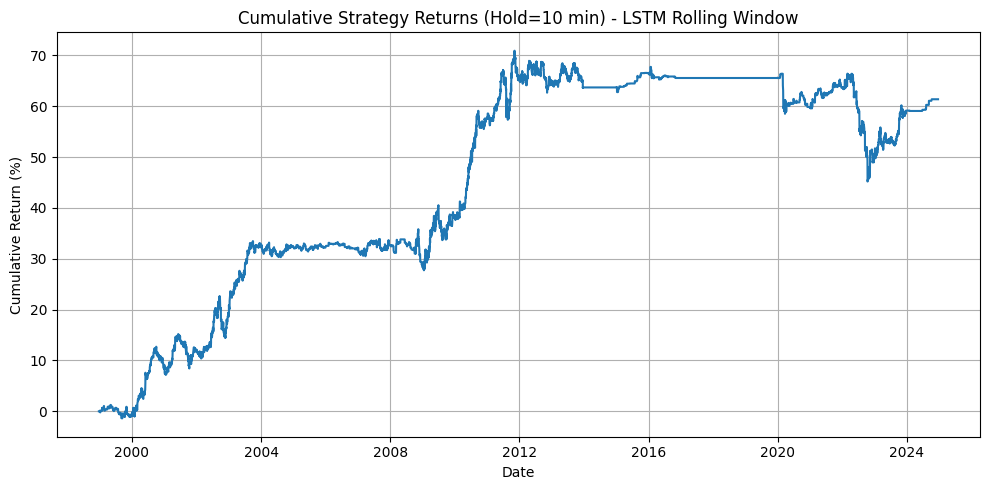


===== Processing Holding Period: 20 minutes =====
  Preparing target variable for 20 min window...
  Prepared 10038 events with targets for 20 min window.

  --- Fold 1 (20 min) ---
    Train Period: 1997-12-23 to 1998-12-23
    Test Period:  1998-12-23 to 1999-12-23
    Train events: 117, Test events: 271
    Preprocessing complete for fold. Num features: 36
    Creating training sequences...
    Creating testing sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Sequences created. Train shape: (117, 10, 36), Test shape: (271, 10, 36)
    Defining and Training LSTM Model...
    Training completed in 31 epochs.
    Simulating Trading on Test Period...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
    Fold 1 processing complete.

  --- Fold 2 (20 min) ---
    Train Period: 1998-12-23 to 1999-12-23
    Test Period:  1999-12-23 to 2000-12-23
    Train events: 271, Test events: 292
    Preprocessing complete for fold. Num features: 46
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (271, 10, 46), Test shape: (292, 10, 46)
    Defining and Training LSTM Model...
    Training completed in 30 epochs.
    Simulating Trading on Test Period...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
    Fold 2 processing complete.

  --- Fold 3 (20 min) ---
    Train Period: 1999-12-23 to 2000-12-23
    Test Period:  2000-12-23 to 2001-12-23
    Train events: 292, Test events: 297
    Preprocessing complete for fold. Num features: 46
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (292, 10, 46), Test shape: (297, 10, 46)
    Defining and Training LSTM Model...
    Training completed in 17 epochs.
    Simulating Trading on Test Period...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
    Fold 3 processing complete.

  --- Fold 4 (20 min) ---
    Train Period: 2000-12-23 to 2001-12-23
    Test Period:  2001-12-23 to 2002-12-23
    Train events: 297, Test events: 299
    Preprocessing complete for fold. Num features: 48
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (297, 10, 48), Test shape: (299, 10, 48)
    Defining and Training LSTM Model...
    Training completed in 40 epochs.
    Simulating Trading on Test Period...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
    Fold 4 processing complete.

  --- Fold 5 (20 min) ---
    Train Period: 2001-12-23 to 2002-12-23
    Test Period:  2002-12-23 to 2003-12-23
    Train events: 299, Test events: 311
    Preprocessing complete for fold. Num features: 52
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (299, 10, 52), Test shape: (311, 10, 52)
    Defining and Training LSTM Model...
    Training completed in 33 epochs.
    Simulating Trading on Test Period...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
    Fold 5 processing complete.

  --- Fold 6 (20 min) ---
    Train Period: 2002-12-23 to 2003-12-23
    Test Period:  2003-12-23 to 2004-12-23
    Train events: 311, Test events: 333
    Preprocessing complete for fold. Num features: 54
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (311, 10, 54), Test shape: (333, 10, 54)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
    Fold 6 processing complete.

  --- Fold 7 (20 min) ---
    Train Period: 2003-12-23 to 2004-12-23
    Test Period:  2004-12-23 to 2005-12-23
    Train events: 333, Test events: 342
    Preprocessing complete for fold. Num features: 56
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (333, 10, 56), Test shape: (342, 10, 56)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
    Fold 7 processing complete.

  --- Fold 8 (20 min) ---
    Train Period: 2004-12-23 to 2005-12-23
    Test Period:  2005-12-23 to 2006-12-23
    Train events: 342, Test events: 358
    Preprocessing complete for fold. Num features: 66
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (342, 10, 66), Test shape: (358, 10, 66)
    Defining and Training LSTM Model...
    Training completed in 34 epochs.
    Simulating Trading on Test Period...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    Fold 8 processing complete.

  --- Fold 9 (20 min) ---
    Train Period: 2005-12-23 to 2006-12-23
    Test Period:  2006-12-23 to 2007-12-23
    Train events: 358, Test events: 374
    Preprocessing complete for fold. Num features: 62
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (358, 10, 62), Test shape: (374, 10, 62)
    Defining and Training LSTM Model...
    Training completed in 25 epochs.
    Simulating Trading on Test Period...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
    Fold 9 processing complete.

  --- Fold 10 (20 min) ---
    Train Period: 2006-12-23 to 2007-12-23
    Test Period:  2007-12-23 to 2008-12-23
    Train events: 374, Test events: 402
    Preprocessing complete for fold. Num features: 73
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (374, 10, 73), Test shape: (402, 10, 73)
    Defining and Training LSTM Model...
    Training completed in 21 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 10 processing complete.

  --- Fold 11 (20 min) ---
    Train Period: 2007-12-23 to 2008-12-23
    Test Period:  2008-12-23 to 2009-12-23
    Train events: 402, Test events: 411
    Preprocessing complete for fold. Num features: 75
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (402, 10, 75), Test shape: (411, 10, 75)
    Defining and Training LSTM Model...
    Training completed in 23 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 11 processing complete.

  --- Fold 12 (20 min) ---
    Train Period: 2008-12-23 to 2009-12-23
    Test Period:  2009-12-23 to 2010-12-23
    Train events: 411, Test events: 429
    Preprocessing complete for fold. Num features: 71
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (411, 10, 71), Test shape: (429, 10, 71)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 12 processing complete.

  --- Fold 13 (20 min) ---
    Train Period: 2009-12-23 to 2010-12-23
    Test Period:  2010-12-23 to 2011-12-23
    Train events: 429, Test events: 455
    Preprocessing complete for fold. Num features: 78
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (429, 10, 78), Test shape: (455, 10, 78)
    Defining and Training LSTM Model...
    Training completed in 12 epochs.
    Simulating Trading on Test Period...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    Fold 13 processing complete.

  --- Fold 14 (20 min) ---
    Train Period: 2010-12-23 to 2011-12-23
    Test Period:  2011-12-23 to 2012-12-23
    Train events: 455, Test events: 450
    Preprocessing complete for fold. Num features: 86
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (455, 10, 86), Test shape: (450, 10, 86)
    Defining and Training LSTM Model...
    Training completed in 26 epochs.
    Simulating Trading on Test Period...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    Fold 14 processing complete.

  --- Fold 15 (20 min) ---
    Train Period: 2011-12-23 to 2012-12-23
    Test Period:  2012-12-23 to 2013-12-23
    Train events: 450, Test events: 434
    Preprocessing complete for fold. Num features: 83
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (450, 10, 83), Test shape: (434, 10, 83)
    Defining and Training LSTM Model...
    Training completed in 13 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    Fold 15 processing complete.

  --- Fold 16 (20 min) ---
    Train Period: 2012-12-23 to 2013-12-23
    Test Period:  2013-12-23 to 2014-12-23
    Train events: 434, Test events: 442
    Preprocessing complete for fold. Num features: 84
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (434, 10, 84), Test shape: (442, 10, 84)
    Defining and Training LSTM Model...
    Training completed in 12 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    Fold 16 processing complete.

  --- Fold 17 (20 min) ---
    Train Period: 2013-12-23 to 2014-12-23
    Test Period:  2014-12-23 to 2015-12-23
    Train events: 442, Test events: 446
    Preprocessing complete for fold. Num features: 81
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (442, 10, 81), Test shape: (446, 10, 81)
    Defining and Training LSTM Model...
    Training completed in 36 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    Fold 17 processing complete.

  --- Fold 18 (20 min) ---
    Train Period: 2014-12-23 to 2015-12-23
    Test Period:  2015-12-23 to 2016-12-23
    Train events: 446, Test events: 407
    Preprocessing complete for fold. Num features: 88
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (446, 10, 88), Test shape: (407, 10, 88)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    Fold 18 processing complete.

  --- Fold 19 (20 min) ---
    Train Period: 2015-12-23 to 2016-12-23
    Test Period:  2016-12-23 to 2017-12-23
    Train events: 407, Test events: 403
    Preprocessing complete for fold. Num features: 88
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (407, 10, 88), Test shape: (403, 10, 88)
    Defining and Training LSTM Model...
    Training completed in 23 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 19 processing complete.

  --- Fold 20 (20 min) ---
    Train Period: 2016-12-23 to 2017-12-23
    Test Period:  2017-12-23 to 2018-12-23
    Train events: 403, Test events: 395
    Preprocessing complete for fold. Num features: 82
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (403, 10, 82), Test shape: (395, 10, 82)
    Defining and Training LSTM Model...
    Training completed in 57 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 20 processing complete.

  --- Fold 21 (20 min) ---
    Train Period: 2017-12-23 to 2018-12-23
    Test Period:  2018-12-23 to 2019-12-23
    Train events: 395, Test events: 393
    Preprocessing complete for fold. Num features: 83
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (395, 10, 83), Test shape: (393, 10, 83)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 21 processing complete.

  --- Fold 22 (20 min) ---
    Train Period: 2018-12-23 to 2019-12-23
    Test Period:  2019-12-23 to 2020-12-23
    Train events: 393, Test events: 407
    Preprocessing complete for fold. Num features: 89
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (393, 10, 89), Test shape: (407, 10, 89)
    Defining and Training LSTM Model...
    Training completed in 33 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 22 processing complete.

  --- Fold 23 (20 min) ---
    Train Period: 2019-12-23 to 2020-12-23
    Test Period:  2020-12-23 to 2021-12-23
    Train events: 407, Test events: 389
    Preprocessing complete for fold. Num features: 88
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (407, 10, 88), Test shape: (389, 10, 88)
    Defining and Training LSTM Model...
    Training completed in 37 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 23 processing complete.

  --- Fold 24 (20 min) ---
    Train Period: 2020-12-23 to 2021-12-23
    Test Period:  2021-12-23 to 2022-12-23
    Train events: 389, Test events: 402
    Preprocessing complete for fold. Num features: 88
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (389, 10, 88), Test shape: (402, 10, 88)
    Defining and Training LSTM Model...
    Training completed in 13 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 24 processing complete.

  --- Fold 25 (20 min) ---
    Train Period: 2021-12-23 to 2022-12-23
    Test Period:  2022-12-23 to 2023-12-23
    Train events: 402, Test events: 393
    Preprocessing complete for fold. Num features: 86
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (402, 10, 86), Test shape: (393, 10, 86)
    Defining and Training LSTM Model...
    Training completed in 23 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 25 processing complete.

  --- Fold 26 (20 min) ---
    Train Period: 2022-12-23 to 2023-12-23
    Test Period:  2023-12-23 to 2024-12-19
    Train events: 393, Test events: 402
    Preprocessing complete for fold. Num features: 94
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (393, 10, 94), Test shape: (402, 10, 94)
    Defining and Training LSTM Model...
    Training completed in 13 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 26 processing complete.
  Stopping rolling window: Test period start (2024-12-23) is beyond data end (2024-12-18).

  Finished Rolling Window Analysis for 20 min in 164.22 seconds.
  Overall Accuracy (Signal vs Predicted): 39.3610%
  Total Return: 13.4691%
  Plotting cumulative returns for 20 min window (LSTM - Combined Folds)...


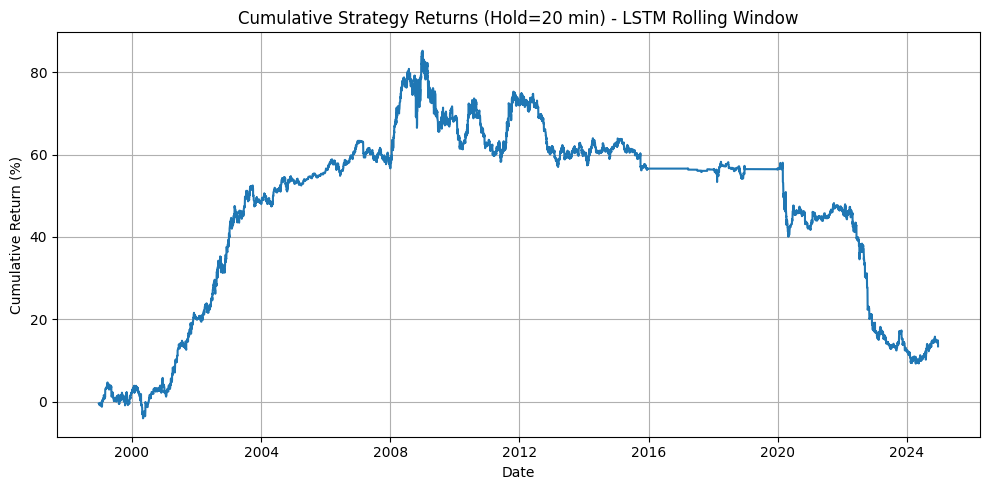


===== Processing Holding Period: 40 minutes =====
  Preparing target variable for 40 min window...
  Prepared 10038 events with targets for 40 min window.

  --- Fold 1 (40 min) ---
    Train Period: 1997-12-23 to 1998-12-23
    Test Period:  1998-12-23 to 1999-12-23
    Train events: 117, Test events: 271
    Preprocessing complete for fold. Num features: 36
    Creating training sequences...
    Creating testing sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Sequences created. Train shape: (117, 10, 36), Test shape: (271, 10, 36)
    Defining and Training LSTM Model...
    Training completed in 30 epochs.
    Simulating Trading on Test Period...
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
    Fold 1 processing complete.

  --- Fold 2 (40 min) ---
    Train Period: 1998-12-23 to 1999-12-23
    Test Period:  1999-12-23 to 2000-12-23
    Train events: 271, Test events: 292
    Preprocessing complete for fold. Num features: 46
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (271, 10, 46), Test shape: (292, 10, 46)
    Defining and Training LSTM Model...
    Training completed in 23 epochs.
    Simulating Trading on Test Period...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
    Fold 2 processing complete.

  --- Fold 3 (40 min) ---
    Train Period: 1999-12-23 to 2000-12-23
    Test Period:  2000-12-23 to 2001-12-23
    Train events: 292, Test events: 297
    Preprocessing complete for fold. Num features: 46
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (292, 10, 46), Test shape: (297, 10, 46)
    Defining and Training LSTM Model...
    Training completed in 14 epochs.
    Simulating Trading on Test Period...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
    Fold 3 processing complete.

  --- Fold 4 (40 min) ---
    Train Period: 2000-12-23 to 2001-12-23
    Test Period:  2001-12-23 to 2002-12-23
    Train events: 297, Test events: 299
    Preprocessing complete for fold. Num features: 48
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (297, 10, 48), Test shape: (299, 10, 48)
    Defining and Training LSTM Model...
    Training completed in 13 epochs.
    Simulating Trading on Test Period...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
    Fold 4 processing complete.

  --- Fold 5 (40 min) ---
    Train Period: 2001-12-23 to 2002-12-23
    Test Period:  2002-12-23 to 2003-12-23
    Train events: 299, Test events: 311
    Preprocessing complete for fold. Num features: 52
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (299, 10, 52), Test shape: (311, 10, 52)
    Defining and Training LSTM Model...
    Training completed in 33 epochs.
    Simulating Trading on Test Period...
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
    Fold 5 processing complete.

  --- Fold 6 (40 min) ---
    Train Period: 2002-12-23 to 2003-12-23
    Test Period:  2003-12-23 to 2004-12-23
    Train events: 311, Test events: 333
    Preprocessing complete for fold. Num features: 54
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (311, 10, 54), Test shape: (333, 10, 54)
    Defining and Training LSTM Model...
    Training completed in 13 epochs.
    Simulating Trading on Test Period...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
    Fold 6 processing complete.

  --- Fold 7 (40 min) ---
    Train Period: 2003-12-23 to 2004-12-23
    Test Period:  2004-12-23 to 2005-12-23
    Train events: 333, Test events: 342
    Preprocessing complete for fold. Num features: 56
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (333, 10, 56), Test shape: (342, 10, 56)
    Defining and Training LSTM Model...
    Training completed in 24 epochs.
    Simulating Trading on Test Period...
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    Fold 7 processing complete.

  --- Fold 8 (40 min) ---
    Train Period: 2004-12-23 to 2005-12-23
    Test Period:  2005-12-23 to 2006-12-23
    Train events: 342, Test events: 358
    Preprocessing complete for fold. Num features: 66
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (342, 10, 66), Test shape: (358, 10, 66)
    Defining and Training LSTM Model...
    Training completed in 14 epochs.
    Simulating Trading on Test Period...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    Fold 8 processing complete.

  --- Fold 9 (40 min) ---
    Train Period: 2005-12-23 to 2006-12-23
    Test Period:  2006-12-23 to 2007-12-23
    Train events: 358, Test events: 374
    Preprocessing complete for fold. Num features: 62
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (358, 10, 62), Test shape: (374, 10, 62)
    Defining and Training LSTM Model...
    Training completed in 16 epochs.
    Simulating Trading on Test Period...
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    Fold 9 processing complete.

  --- Fold 10 (40 min) ---
    Train Period: 2006-12-23 to 2007-12-23
    Test Period:  2007-12-23 to 2008-12-23
    Train events: 374, Test events: 402
    Preprocessing complete for fold. Num features: 73
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (374, 10, 73), Test shape: (402, 10, 73)
    Defining and Training LSTM Model...
    Training completed in 22 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 10 processing complete.

  --- Fold 11 (40 min) ---
    Train Period: 2007-12-23 to 2008-12-23
    Test Period:  2008-12-23 to 2009-12-23
    Train events: 402, Test events: 411
    Preprocessing complete for fold. Num features: 75
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (402, 10, 75), Test shape: (411, 10, 75)
    Defining and Training LSTM Model...
    Training completed in 13 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 11 processing complete.

  --- Fold 12 (40 min) ---
    Train Period: 2008-12-23 to 2009-12-23
    Test Period:  2009-12-23 to 2010-12-23
    Train events: 411, Test events: 429
    Preprocessing complete for fold. Num features: 71
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (411, 10, 71), Test shape: (429, 10, 71)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    Fold 12 processing complete.

  --- Fold 13 (40 min) ---
    Train Period: 2009-12-23 to 2010-12-23
    Test Period:  2010-12-23 to 2011-12-23
    Train events: 429, Test events: 455
    Preprocessing complete for fold. Num features: 78
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (429, 10, 78), Test shape: (455, 10, 78)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    Fold 13 processing complete.

  --- Fold 14 (40 min) ---
    Train Period: 2010-12-23 to 2011-12-23
    Test Period:  2011-12-23 to 2012-12-23
    Train events: 455, Test events: 450
    Preprocessing complete for fold. Num features: 86
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (455, 10, 86), Test shape: (450, 10, 86)
    Defining and Training LSTM Model...
    Training completed in 12 epochs.
    Simulating Trading on Test Period...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    Fold 14 processing complete.

  --- Fold 15 (40 min) ---
    Train Period: 2011-12-23 to 2012-12-23
    Test Period:  2012-12-23 to 2013-12-23
    Train events: 450, Test events: 434
    Preprocessing complete for fold. Num features: 83
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (450, 10, 83), Test shape: (434, 10, 83)
    Defining and Training LSTM Model...
    Training completed in 31 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
    Fold 15 processing complete.

  --- Fold 16 (40 min) ---
    Train Period: 2012-12-23 to 2013-12-23
    Test Period:  2013-12-23 to 2014-12-23
    Train events: 434, Test events: 442
    Preprocessing complete for fold. Num features: 84
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (434, 10, 84), Test shape: (442, 10, 84)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    Fold 16 processing complete.

  --- Fold 17 (40 min) ---
    Train Period: 2013-12-23 to 2014-12-23
    Test Period:  2014-12-23 to 2015-12-23
    Train events: 442, Test events: 446
    Preprocessing complete for fold. Num features: 81
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (442, 10, 81), Test shape: (446, 10, 81)
    Defining and Training LSTM Model...
    Training completed in 12 epochs.
    Simulating Trading on Test Period...
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
    Fold 17 processing complete.

  --- Fold 18 (40 min) ---
    Train Period: 2014-12-23 to 2015-12-23
    Test Period:  2015-12-23 to 2016-12-23
    Train events: 446, Test events: 407
    Preprocessing complete for fold. Num features: 88
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (446, 10, 88), Test shape: (407, 10, 88)
    Defining and Training LSTM Model...
    Training completed in 15 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 18 processing complete.

  --- Fold 19 (40 min) ---
    Train Period: 2015-12-23 to 2016-12-23
    Test Period:  2016-12-23 to 2017-12-23
    Train events: 407, Test events: 403
    Preprocessing complete for fold. Num features: 88
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (407, 10, 88), Test shape: (403, 10, 88)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 19 processing complete.

  --- Fold 20 (40 min) ---
    Train Period: 2016-12-23 to 2017-12-23
    Test Period:  2017-12-23 to 2018-12-23
    Train events: 403, Test events: 395
    Preprocessing complete for fold. Num features: 82
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (403, 10, 82), Test shape: (395, 10, 82)
    Defining and Training LSTM Model...
    Training completed in 22 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 20 processing complete.

  --- Fold 21 (40 min) ---
    Train Period: 2017-12-23 to 2018-12-23
    Test Period:  2018-12-23 to 2019-12-23
    Train events: 395, Test events: 393
    Preprocessing complete for fold. Num features: 83
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (395, 10, 83), Test shape: (393, 10, 83)
    Defining and Training LSTM Model...
    Training completed in 15 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 21 processing complete.

  --- Fold 22 (40 min) ---
    Train Period: 2018-12-23 to 2019-12-23
    Test Period:  2019-12-23 to 2020-12-23
    Train events: 393, Test events: 407
    Preprocessing complete for fold. Num features: 89
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (393, 10, 89), Test shape: (407, 10, 89)
    Defining and Training LSTM Model...
    Training completed in 11 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
    Fold 22 processing complete.

  --- Fold 23 (40 min) ---
    Train Period: 2019-12-23 to 2020-12-23
    Test Period:  2020-12-23 to 2021-12-23
    Train events: 407, Test events: 389
    Preprocessing complete for fold. Num features: 88
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (407, 10, 88), Test shape: (389, 10, 88)
    Defining and Training LSTM Model...
    Training completed in 32 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    Fold 23 processing complete.

  --- Fold 24 (40 min) ---
    Train Period: 2020-12-23 to 2021-12-23
    Test Period:  2021-12-23 to 2022-12-23
    Train events: 389, Test events: 402
    Preprocessing complete for fold. Num features: 88
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (389, 10, 88), Test shape: (402, 10, 88)
    Defining and Training LSTM Model...
    Training completed in 31 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
    Fold 24 processing complete.

  --- Fold 25 (40 min) ---
    Train Period: 2021-12-23 to 2022-12-23
    Test Period:  2022-12-23 to 2023-12-23
    Train events: 402, Test events: 393
    Preprocessing complete for fold. Num features: 86
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (402, 10, 86), Test shape: (393, 10, 86)
    Defining and Training LSTM Model...
    Training completed in 12 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    Fold 25 processing complete.

  --- Fold 26 (40 min) ---
    Train Period: 2022-12-23 to 2023-12-23
    Test Period:  2023-12-23 to 2024-12-19
    Train events: 393, Test events: 402
    Preprocessing complete for fold. Num features: 94
    Creating training sequences...


c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\Jop Brouwer\Documents\GitHub\Data-Science-Seminar-Group-Project-5\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


    Creating testing sequences...
    Sequences created. Train shape: (393, 10, 94), Test shape: (402, 10, 94)
    Defining and Training LSTM Model...
    Training completed in 18 epochs.
    Simulating Trading on Test Period...
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
    Fold 26 processing complete.
  Stopping rolling window: Test period start (2024-12-23) is beyond data end (2024-12-18).

  Finished Rolling Window Analysis for 40 min in 147.61 seconds.
  Overall Accuracy (Signal vs Predicted): 38.0506%
  Total Return: 26.9170%
  Plotting cumulative returns for 40 min window (LSTM - Combined Folds)...


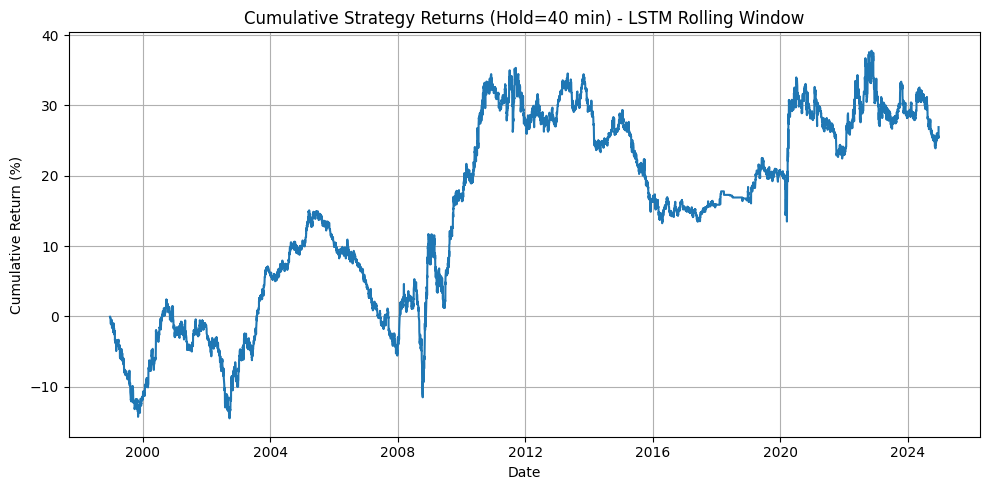



===== Final Summary Results Across All Window Sizes (LSTM - Rolling Window Validation) =====
| window_minutes   | total_return   | overall_accuracy   | num_trades   | yearly_returns_str                                                                                                                                                                                                                                                                                                                                                             |
|:-----------------|:---------------|:-------------------|:-------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 10               

In [14]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, TimeDistributed, Masking
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import time # To time the process
import datetime
import warnings

# Suppress specific warnings if desired
# warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)
# warnings.filterwarnings('ignore', category=FutureWarning) # Suppress the FutureWarning specifically if needed

# Attempt to import matplotlib for plotting
try:
    import matplotlib.pyplot as plt
    MATPLOTLIB_AVAILABLE = True
except ImportError:
    MATPLOTLIB_AVAILABLE = False
    print("Warning: matplotlib not found. Install using 'pip install matplotlib' to see performance plots.")

# --- Check TensorFlow Installation ---
try:
    print(f"TensorFlow version: {tf.__version__}")
except NameError:
    print("TensorFlow not found. Please install it using 'pip install tensorflow'")
    exit()
except Exception as e:
    print(f"An error occurred importing TensorFlow: {e}")
    exit()

# --- Configuration ---
WINDOW_SIZES = [10, 20, 40] # Holding periods to test in minutes
RETURN_THRESHOLD = 0.0005  # Threshold for defining Long/Short signal
# LSTM Parameters
SEQUENCE_LENGTH = 10       # Number of time steps (minutes) leading up to and including the event
N_LAGGED_RETURNS = 5       # How many lagged 1-min returns to include as features
# Rolling Window Parameters
TRAIN_WINDOW_YEARS = 1
TEST_WINDOW_YEARS = 1
# NN Parameters
LSTM_UNITS_1 = 64          # Units in first LSTM layer
LSTM_UNITS_2 = 32          # Units in second LSTM layer
DROPOUT_RATE = 0.3
EPOCHS = 100
PATIENCE = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.001

# --- Load and Initial Prepare Data (Do this once) ---
print("--- Loading and Initial Data Preparation ---")
try:
    if 'df_combined' not in locals() and 'df_combined' not in globals():
         raise NameError("df_combined is not defined. Please load your data.")

    df_base = df_combined.copy()
    df_base['DateTime'] = pd.to_datetime(df_base['DateTime'], errors='coerce')
    df_base = df_base.dropna(subset=['DateTime'])
    df_base = df_base.sort_values('DateTime')
    df_base = df_base.set_index('DateTime')
    print("DateTime column processed and set as index for base DataFrame.")

    required_cols = ['Close', 'Event', 'Surprise']
    missing_cols = [col for col in required_cols if col not in df_base.columns]
    if missing_cols:
        raise ValueError(f"Error: Missing required columns: {missing_cols}")

    # Calculate lagged returns ONCE on the base data
    for i in range(1, N_LAGGED_RETURNS + 1):
        # Use fillna(0) immediately after pct_change if NaNs at start are expected
        df_base[f'Return_{i}min_ago'] = df_base['Close'].pct_change(periods=i).fillna(0)

    # Keep only relevant columns now, including lagged returns
    cols_to_keep = ['Close', 'Event', 'Surprise'] + [f'Return_{i}min_ago' for i in range(1, N_LAGGED_RETURNS + 1)]
    df_base_features = df_base[cols_to_keep].copy()

    # Filter for surprise events
    df_analysis_base = df_base_features.dropna(subset=['Surprise', 'Event']).copy()

    if df_analysis_base.empty:
        raise ValueError("No rows with surprise events found in the entire dataset.")

    # Handle duplicate indices in the base analysis dataframe BEFORE using it for lookups
    if df_analysis_base.index.duplicated().any():
        print(f"Warning: Found {df_analysis_base.index.duplicated().sum()} duplicate timestamps in surprise events. Keeping first occurrence for each.")
        df_analysis_base = df_analysis_base[~df_analysis_base.index.duplicated(keep='first')]

    print(f"Base DataFrame prepared with lagged returns. Found {len(df_analysis_base)} potential surprise events overall (after handling duplicates).")
    data_start_date = df_analysis_base.index.min()
    data_end_date = df_analysis_base.index.max()
    print(f"Data range for events: {data_start_date} to {data_end_date}")

except FileNotFoundError:
    print("Error: CSV file not found.")
    exit()
except NameError as e:
    print(f"Error: {e}")
    exit()
except KeyError:
    print("Error: 'DateTime' column not found.")
    exit()
except ValueError as e:
     print(e)
     exit()
except Exception as e:
    print(f"An error occurred during initial data preparation: {e}")
    exit()


# --- Helper Function to Create Sequences ---
def create_sequences(data_fold, base_data_with_lags, sequence_length, features_for_lstm, target_col):
    """
    Creates sequences for LSTM input.
    Assumes base_data_with_lags has a unique index.
    """
    X_seq, y_seq = [], []
    event_indices = data_fold.index # Timestamps of the surprise events in this fold

    for event_time in event_indices:
        seq_end_time = event_time
        # Generate the precise index for the sequence window using 'min' instead of 'T'
        full_minute_index = pd.date_range(end=seq_end_time, periods=sequence_length, freq='min') # <-- FIX APPLIED HERE

        # Reindex the base lookup data to this exact window
        sequence_data = base_data_with_lags.reindex(full_minute_index)

        # Keep only the required features for the LSTM
        sequence_features = sequence_data[features_for_lstm].copy()

        # --- Handling Surprise/Event Padding ---
        surprise_cols = [col for col in features_for_lstm if 'Surprise' in col or col.startswith('Event_')]
        if surprise_cols:
            mask_not_event_time = sequence_features.index != event_time
            sequence_features.loc[mask_not_event_time, surprise_cols] = 0

        # --- Handling NaNs ---
        sequence_features = sequence_features.fillna(0)

        # Append sequence and target
        if len(sequence_features) == sequence_length:
            X_seq.append(sequence_features.values)
            y_seq.append(data_fold.loc[event_time, target_col])
        else:
             print(f"Warning: Sequence length mismatch for event {event_time}. Expected {sequence_length}, got {len(sequence_features)}. Skipping.")


    return np.array(X_seq), np.array(y_seq)


# --- Main Loop for Different Holding Periods ---
all_window_results = []

for window_minutes in WINDOW_SIZES:
    print(f"\n===== Processing Holding Period: {window_minutes} minutes =====")
    start_time_window = time.time()

    # --- Prepare data specific to this holding period ---
    print(f"  Preparing target variable for {window_minutes} min window...")
    df_analysis_window = df_analysis_base.copy()
    df_analysis_window['Future_Close'] = df_analysis_window.index.map(lambda dt: df_base['Close'].asof(dt + pd.Timedelta(minutes=window_minutes)))
    df_analysis_window['Future_Return'] = (df_analysis_window['Future_Close'] - df_analysis_window['Close']) / df_analysis_window['Close']
    df_analysis_window = df_analysis_window.dropna(subset=['Future_Return'])

    if df_analysis_window.empty:
        print(f"  Error: No analysable events remaining after calculating future returns for {window_minutes} min window. Skipping.")
        continue

    df_analysis_window['Signal'] = 0
    df_analysis_window.loc[df_analysis_window['Future_Return'] > RETURN_THRESHOLD, 'Signal'] = 1
    df_analysis_window.loc[df_analysis_window['Future_Return'] < -RETURN_THRESHOLD, 'Signal'] = -1
    signal_mapping = {-1: 0, 0: 1, 1: 2}
    df_analysis_window['Target'] = df_analysis_window['Signal'].map(signal_mapping)
    print(f"  Prepared {len(df_analysis_window)} events with targets for {window_minutes} min window.")

    # --- Rolling Window Loop ---
    all_fold_results_df = []
    fold_num = 0
    current_train_start_date = data_start_date

    while True:
        fold_num += 1
        current_train_end_date = current_train_start_date + pd.DateOffset(years=TRAIN_WINDOW_YEARS)
        current_test_start_date = current_train_end_date
        current_test_end_date = current_test_start_date + pd.DateOffset(years=TEST_WINDOW_YEARS)

        if current_test_start_date >= data_end_date:
            print(f"  Stopping rolling window: Test period start ({current_test_start_date.date()}) is beyond data end ({data_end_date.date()}).")
            break

        current_test_end_date = min(current_test_end_date, data_end_date + pd.Timedelta(days=1))

        print(f"\n  --- Fold {fold_num} ({window_minutes} min) ---")
        print(f"    Train Period: {current_train_start_date.date()} to {current_train_end_date.date()}")
        print(f"    Test Period:  {current_test_start_date.date()} to {current_test_end_date.date()}")

        train_df_fold = df_analysis_window.loc[current_train_start_date:current_train_end_date]
        test_df_fold = df_analysis_window.loc[current_test_start_date:current_test_end_date]

        if train_df_fold.empty or test_df_fold.empty:
            print("    Warning: Skipping fold - not enough data in train or test period.")
            current_train_start_date = current_test_start_date
            continue

        print(f"    Train events: {len(train_df_fold)}, Test events: {len(test_df_fold)}")

        numeric_features = ['Surprise'] + [f'Return_{i}min_ago' for i in range(1, N_LAGGED_RETURNS + 1)]
        categorical_features = ['Event']
        cols_needed_for_train = numeric_features + categorical_features + ['Target']
        cols_needed_for_test = numeric_features + categorical_features + ['Target', 'Future_Return', 'Signal']

        train_df_fold = train_df_fold[cols_needed_for_train].copy()
        test_df_fold = test_df_fold[cols_needed_for_test].copy()

        preprocessor = ColumnTransformer(
            transformers=[
                ('num', StandardScaler(), numeric_features),
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), categorical_features)
            ],
            remainder='passthrough'
        )

        features_to_process = numeric_features + categorical_features
        preprocessor.fit(train_df_fold[features_to_process])

        try:
            ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
            processed_feature_names = numeric_features + list(ohe_feature_names)
        except AttributeError:
             print("Warning: Could not automatically get OHE feature names. Using generic names.")
             num_ohe_features = preprocessor.named_transformers_['cat'].categories_[0].shape[0] -1
             ohe_feature_names = [f"Event_{i}" for i in range(num_ohe_features)]
             processed_feature_names = numeric_features + ohe_feature_names

        X_train_processed_fold = preprocessor.transform(train_df_fold[features_to_process])
        X_test_processed_fold = preprocessor.transform(test_df_fold[features_to_process])

        train_processed_df = pd.DataFrame(X_train_processed_fold, index=train_df_fold.index, columns=processed_feature_names)
        test_processed_df = pd.DataFrame(X_test_processed_fold, index=test_df_fold.index, columns=processed_feature_names)

        train_processed_df['Target'] = train_df_fold['Target']
        test_processed_df['Target'] = test_df_fold['Target']

        print(f"    Preprocessing complete for fold. Num features: {len(processed_feature_names)}")

        base_features_for_transform = df_analysis_base[features_to_process]
        base_processed_data = preprocessor.transform(base_features_for_transform)

        base_processed_for_lookup = pd.DataFrame(
             base_processed_data,
             index=df_analysis_base.index,
             columns=processed_feature_names
        )

        print("    Creating training sequences...")
        X_train_seq, y_train_seq = create_sequences(train_processed_df, base_processed_for_lookup, SEQUENCE_LENGTH, processed_feature_names, 'Target')
        print("    Creating testing sequences...")
        X_test_seq, y_test_seq = create_sequences(test_processed_df, base_processed_for_lookup, SEQUENCE_LENGTH, processed_feature_names, 'Target')

        if X_train_seq.size == 0 or X_test_seq.size == 0:
             print("    Warning: Skipping fold - sequence creation resulted in empty arrays.")
             current_train_start_date = current_test_start_date
             continue

        y_train_cat = to_categorical(y_train_seq, num_classes=3)
        y_test_cat = to_categorical(y_test_seq, num_classes=3)
        print(f"    Sequences created. Train shape: {X_train_seq.shape}, Test shape: {X_test_seq.shape}")

        print("    Defining and Training LSTM Model...")
        n_features = X_train_seq.shape[2]
        model = Sequential(name=f"MacroSurprise_LSTM_{window_minutes}min_Fold{fold_num}")
        model.add(Input(shape=(SEQUENCE_LENGTH, n_features)))
        model.add(LSTM(LSTM_UNITS_1, return_sequences=True))
        model.add(Dropout(DROPOUT_RATE))
        model.add(LSTM(LSTM_UNITS_2, return_sequences=False))
        model.add(Dropout(DROPOUT_RATE))
        model.add(Dense(3, activation='softmax'))

        optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True, verbose=0)

        if len(X_train_seq) > 5: val_split = 0.2
        else: val_split = 0.0

        history = model.fit(X_train_seq, y_train_cat,
                            epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=val_split,
                            callbacks=[early_stopping], verbose=0)
        print(f"    Training completed in {history.epoch[-1]+1} epochs.")

        print("    Simulating Trading on Test Period...")
        predictions_prob = model.predict(X_test_seq)
        predicted_signals_raw = np.argmax(predictions_prob, axis=1)
        reverse_signal_mapping = {0: -1, 1: 0, 2: 1}
        predicted_signals = np.array([reverse_signal_mapping[pred] for pred in predicted_signals_raw])

        event_times_in_test_seq = test_processed_df.index[:len(predicted_signals)]
        fold_result_df = test_df_fold.loc[event_times_in_test_seq].copy()

        if len(fold_result_df) != len(predicted_signals):
            print(f"    Error: Length mismatch after alignment. Preds: {len(predicted_signals)}, Aligned DF: {len(fold_result_df)}. Skipping fold results.")
            current_train_start_date = current_test_start_date
            continue

        fold_result_df['Predicted_Signal'] = predicted_signals
        fold_result_df['Strategy_Return'] = 0.0

        long_mask = fold_result_df['Predicted_Signal'] == 1
        short_mask = fold_result_df['Predicted_Signal'] == -1
        fold_result_df.loc[long_mask, 'Strategy_Return'] = fold_result_df.loc[long_mask, 'Future_Return'].values
        fold_result_df.loc[short_mask, 'Strategy_Return'] = -fold_result_df.loc[short_mask, 'Future_Return'].values

        all_fold_results_df.append(fold_result_df)
        print(f"    Fold {fold_num} processing complete.")

        current_train_start_date = current_test_start_date


    # --- Aggregation and Evaluation for the holding period ---
    if not all_fold_results_df:
        print(f"  No results generated for holding period {window_minutes} min. Skipping.")
        continue

    combined_test_results = pd.concat(all_fold_results_df).sort_index()
    combined_test_results = combined_test_results[~combined_test_results.index.duplicated(keep='first')]

    if (combined_test_results['Strategy_Return'] != 0).any():
         combined_test_results['Cumulative_Strategy_Return'] = (1 + combined_test_results['Strategy_Return']).cumprod() - 1
    else:
         combined_test_results['Cumulative_Strategy_Return'] = 0.0

    total_return = combined_test_results['Cumulative_Strategy_Return'].iloc[-1] if not combined_test_results.empty and pd.notna(combined_test_results['Cumulative_Strategy_Return'].iloc[-1]) else 0
    combined_test_results['Year'] = combined_test_results.index.year
    yearly_returns = combined_test_results.groupby('Year')['Strategy_Return'].apply(lambda x: (1 + x).prod() - 1)

    correct_predictions = (combined_test_results['Signal'] == combined_test_results['Predicted_Signal']).sum()
    total_predictions = len(combined_test_results)
    overall_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0

    num_trades = len(combined_test_results[combined_test_results['Predicted_Signal'] != 0])

    end_time_window = time.time()
    print(f"\n  Finished Rolling Window Analysis for {window_minutes} min in {end_time_window - start_time_window:.2f} seconds.")
    print(f"  Overall Accuracy (Signal vs Predicted): {overall_accuracy:.4%}")
    print(f"  Total Return: {total_return:.4%}")

    all_window_results.append({
        'window_minutes': window_minutes,
        'total_return': total_return,
        'yearly_returns': yearly_returns,
        'overall_accuracy': overall_accuracy,
        'num_trades': num_trades,
        'combined_test_results': combined_test_results
    })

    if MATPLOTLIB_AVAILABLE and not combined_test_results.empty and 'Cumulative_Strategy_Return' in combined_test_results.columns:
        print(f"  Plotting cumulative returns for {window_minutes} min window (LSTM - Combined Folds)...")
        try:
            plt.figure(figsize=(10, 5))
            plt.plot(combined_test_results.index, combined_test_results['Cumulative_Strategy_Return'] * 100)
            plt.title(f'Cumulative Strategy Returns (Hold={window_minutes} min) - LSTM Rolling Window')
            plt.xlabel('Date')
            plt.ylabel('Cumulative Return (%)')
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"   An error occurred during plotting: {e}")


# --- Display Final Summary Results ---
print("\n\n===== Final Summary Results Across All Window Sizes (LSTM - Rolling Window Validation) =====")
if not all_window_results:
    print("No results were generated across any window size.")
else:
    summary_list = []
    for res in all_window_results:
        summary_list.append({
            'window_minutes': res['window_minutes'],
            'total_return': res['total_return'],
            'overall_accuracy': res['overall_accuracy'],
            'num_trades': res['num_trades'],
            'yearly_returns': res['yearly_returns']
        })

    summary_df = pd.DataFrame(summary_list)
    summary_df['total_return'] = summary_df['total_return'].map('{:.4%}'.format)
    summary_df['overall_accuracy'] = summary_df['overall_accuracy'].map('{:.4%}'.format)
    summary_df['yearly_returns_str'] = summary_df['yearly_returns'].apply(
        lambda x: ', '.join([f"{yr}: {ret:.2%}" for yr, ret in x.items()]) if isinstance(x, pd.Series) and not x.empty else "N/A"
    )

    print(summary_df[['window_minutes', 'total_return', 'overall_accuracy', 'num_trades', 'yearly_returns_str']].to_markdown(index=False, numalign="left", stralign="left"))

    print("\nDetailed Yearly Returns (Combined Folds):")
    for res in all_window_results:
        print(f"\n  Window: {res['window_minutes']} minutes")
        if not res['yearly_returns'].empty:
            formatted_yearly = res['yearly_returns'].map('{:.4%}'.format)
            print(formatted_yearly.to_markdown(numalign="left", stralign="left"))
        else:
            print("    No yearly returns calculated.")


# --- Full Explanation ---
print("\n--- Explanation ---")
print(f"""
This script implements and evaluates an **LSTM (Long Short-Term Memory)** based neural network trading strategy using the rolling window validation approach, tested across multiple holding periods ({WINDOW_SIZES} minutes). LSTMs are suitable for sequence data, allowing the model to potentially capture temporal patterns leading up to a surprise event.

1.  **Data Loading and Initial Preparation:**
    * Data is loaded, DateTime index set, and essential columns selected.
    * **Feature Engineering:** Lagged percentage returns are calculated **once** on the base DataFrame.
    * The base dataset for analysis (`df_analysis_base`) includes these lagged returns along with 'Close', 'Event', and 'Surprise', filtered for rows where surprises occurred.
    * **Duplicate Index Handling:** Duplicate timestamps in `df_analysis_base` are handled by keeping only the first occurrence, resolving the `reindex` error encountered previously.

2.  **Outer Loop (Holding Periods):**
    * Iterates through each `window_minutes`.
    * Calculates the `Future_Return` and `Target` variable (Short/NoTrade/Long) for all events based on the current `window_minutes`.

3.  **Inner Loop (Rolling Window Folds):**
    * Implements the {TRAIN_WINDOW_YEARS}-year train / {TEST_WINDOW_YEARS}-year test rolling window.
    * **Fold Data Selection:** Selects training and testing data for the current fold.
    * **Fold-Specific Preprocessing:**
        * A `ColumnTransformer` (StandardScaler for numeric, OneHotEncoder for categorical) is `fit` **only on the current fold's training data**.
        * Transforms both train and test data for the fold.
    * **Sequence Creation (`create_sequences` function):**
        * Transforms the fold's data into sequences.
        * A lookup table (`base_processed_for_lookup`) is created by applying the *current fold's* preprocessor to the *entire* (unique-indexed) `df_analysis_base`.
        * For each surprise event at time `T`:
            * It looks up the relevant processed features for the `SEQUENCE_LENGTH` minutes ending at `T`.
            * Uses `pd.date_range` with `freq='min'` (updated from 'T') to create the index for the sequence window.
            * **Padding:** Sets 'Surprise' and 'Event' features to 0 for timesteps before `T`.
            * Handles NaNs (filling with 0).
        * Outputs 3D sequence arrays (`X..._seq`) and 1D target arrays (`y..._seq`).
    * **Fold-Specific LSTM Model:**
        * A **new** LSTM model is defined and compiled for each fold. Architecture: Input -> LSTM(seq=True) -> Dropout -> LSTM -> Dropout -> Dense(3, softmax).
    * **Fold-Specific Training:** Trains the LSTM model **only on the sequence data of the current fold**. Early stopping is used.
    * **Fold-Specific Prediction & Simulation:**
        * Predicts on the test sequences for the current fold.
        * Aligns predictions back to the original event timestamps.
        * Simulates trading based on LSTM predictions.
    * **Window Rolling:** Moves the window forward for the next fold.

4.  **Aggregation and Evaluation (Per Holding Period):**
    * Concatenates results from all folds, ensuring unique indices.
    * Calculates overall performance metrics (Total Return, Yearly Returns, Accuracy).
    * Plots the cumulative return curve.

5.  **Final Summary:**
    * Presents a summary table comparing the LSTM strategy's performance across the different holding periods, based on the rolling window validation.
""")